# SPAIN ECONOMIC POLICY UNCERTAINTY INDEX - TIME SERIES FORECASTING

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/9/9a/Flag_of_Spain.svg" width="120">
</p>


We've explored the Spain Economic Policy Uncertainty (EPU) Index, a dataset compiled from the Economic Policy Uncertainty website, available at https://www.policyuncertainty.com/. This robust dataset covers the period from 1997 to 2025, providing a comprehensive look at the fluctuations in economic policy uncertainty experienced by Spain over nearly three decades.

### 0. LIBRARIES

In [1]:
%%capture
%pip install plotly statsmodels scikit-learn xgboost pmdarima statsforecast arch

In [177]:
# Core Libraries
import numpy as np
import pandas as pd
import itertools
import warnings
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.patheffects as pe
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.graph_objects as go

# Time Series Analysis & Statistical Models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
import pmdarima as pm
from pmdarima.arima import auto_arima
from scipy.signal import periodogram
from scipy.fft import fft
from scipy import stats

# Volatility Models
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
from statsforecast import StatsForecast
from statsforecast.models import ARCH, GARCH, Naive
from pandas.tseries.offsets import MonthBegin

# Machine Learning
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Deep Learning (Keras/TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError

# Notebook Settings
%matplotlib inline
warnings.filterwarnings('ignore')


In [3]:
import plotly.io as pio
plt.style.use('seaborn-v0_8-white')
sns.set_theme(style="whitegrid")
pio.templates.default = "plotly_white"

### 1. IMPORT DATASET

In [4]:
df = pd.read_excel("https://raw.githubusercontent.com/tphathuin1802/spain-economics-uncertain-forecasting/main/NEW_SPAIN_EPU_INDEX.xlsx",skiprows=1)

In [5]:
df.head() 

Year  Month  Index value
0  1997      1    31.018169
1  1997      2    50.695080
2  1997      3    43.754341
3  1997      4    43.427864
4  1997      5   120.413849

In [6]:
df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
df = df.set_index('Date').sort_index()
df = df.reset_index()
df = df.drop(columns="Year")
df.rename(columns={'Index value': 'EPU'}, inplace=True)
df.head()

Date  Month         EPU
0 1997-01-01      1   31.018169
1 1997-02-01      2   50.695080
2 1997-03-01      3   43.754341
3 1997-04-01      4   43.427864
4 1997-05-01      5  120.413849

### 2. EXPLORY DATA ANALYSIS

In [7]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    340 non-null    datetime64[ns]
 1   Month   340 non-null    int64         
 2   EPU     340 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 8.1 KB


Date       Month         EPU
count                            340  340.000000  340.000000
mean   2011-02-15 02:07:03.529411840    6.452941  112.745058
min              1997-01-01 00:00:00    1.000000   31.018169
25%              2004-01-24 06:00:00    3.000000   80.984438
50%              2011-02-15 00:00:00    6.000000  108.462086
75%              2018-03-08 18:00:00    9.000000  140.231647
max              2025-04-01 00:00:00   12.000000  261.609741
std                              NaN    3.465909   40.348093

The dataset includes 340 monthly records from 1997 to 2025, with no missing values. The EPU shows considerable variation over time, underlining the need for models that can capture trends, seasonality, and volatility.


In [8]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtype'])
    summary_df['missing'] = df.isnull().sum()
    summary_df['duplicates'] = df.duplicated().sum()
    summary_df['missing_per'] = df.isnull().sum() / len(df) * 100
    summary_df['uniques'] = df.nunique().values
    summary_df['count'] = df.count().values
    return summary_df

summary(df).style.background_gradient(cmap='Blues')

A quick overview of the dataset shows no missing or duplicate values, with clear data types and consistent record counts. This confirms data quality for further analysis and modeling.


In [9]:
print("Data shape: ", df.shape)
print(f"Total observations: {len(df)}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Data shape:  (340, 3)
Total observations: 340
Date range: 1997-01-01 00:00:00 to 2025-04-01 00:00:00


To avoid unwant inplace to default dataset, we copy another df name: eda

In [10]:
eda = df.copy() #edadataset
eda.head()

Date  Month         EPU
0 1997-01-01      1   31.018169
1 1997-02-01      2   50.695080
2 1997-03-01      3   43.754341
3 1997-04-01      4   43.427864
4 1997-05-01      5  120.413849

--- 
Plotting the EPU Index over time reveals its evolution from 1997 through 2025. Early years show relatively stable and moderate uncertainty levels. Over time, pronounced peaks appear, reflecting periods of intensified economic or political stress. Especially noticeable are sharp increases around 2012 and 2020, aligning with known global and regional crises. This visualization helps us understand the overall trend and long-term shifts in economic policy uncertainty in Spain.

In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['Date'],
    y=df['EPU'],
    mode='lines',
    name='EPU Index',
    line=dict(color="#2f4b7c", width=2),
))

fig.update_layout(
    title=dict(
        text='<b>SPAIN EPU INDEX VISUALIZATION FROM 1997 TO 2025</b>',
        x=0.5,
        font=dict(size=26)
    ),
    xaxis_title='Date',
    yaxis_title='Value',
    width=1100,
    height=500,
    font=dict(size=15),
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1,
        font=dict(size=15)
    )
)

fig.update_xaxes(
    showgrid=True,
    gridwidth=1.2,
    dtick="M24",
    tickformat="%Y",
    showline=True,
    linewidth=1,
    linecolor='black',
    mirror=True,
    ticklabelstandoff=10 
)

fig.update_yaxes(
    showgrid=True,
    gridwidth=1.2,
    zeroline=True,
    zerolinewidth=1.5,
    showline=True,
    linewidth=1,
    linecolor='black',
    mirror=True,
    ticklabelstandoff=10
)


fig.show()


---
To better capture underlying trends, we apply a 12-month rolling average. This smoothed view highlights periods of sustained high uncertainty. Notably, while short-term fluctuations abound, there is a clear upward drift in the smoothed curve over the years. This suggests that baseline economic policy uncertainty in Spain has gradually increased, moving from lower values in the early 2000s to consistently elevated levels in the 2010s and 2020s.


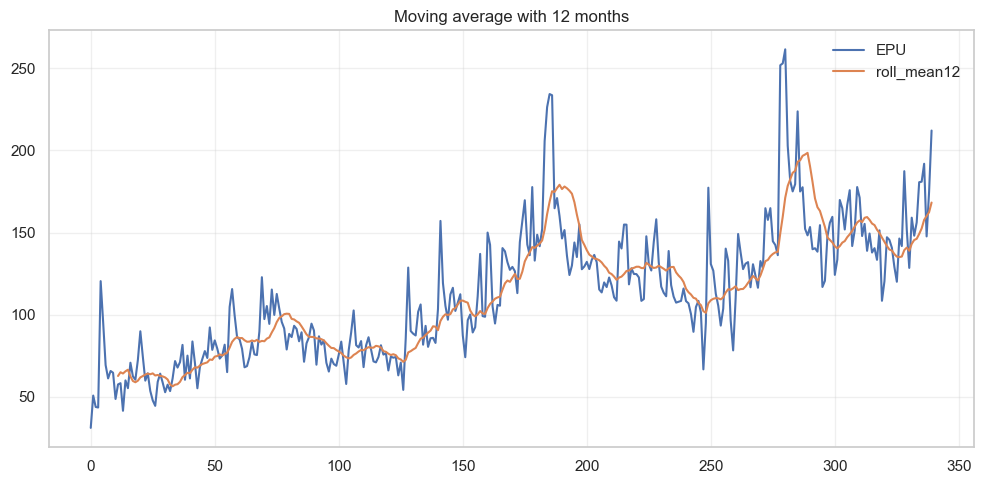

In [12]:
eda["roll_mean12"] = eda["EPU"].rolling(12).mean()
eda[['EPU', 'roll_mean12']].plot(
    figsize=(10, 5),
    linewidth=1.5,
    title="Moving average with 12 months",
)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

--- 
Examining the distribution of the EPU Index shows a right-skewed shape, with most observations clustering between 50 and 150 but with a long tail of high values. This confirms that while moderate uncertainty is typical, there are occasional extreme events driving the index to much higher levels. Understanding this skew is important for modeling and forecasting, as these rare but impactful spikes can heavily influence mean values and volatility. 

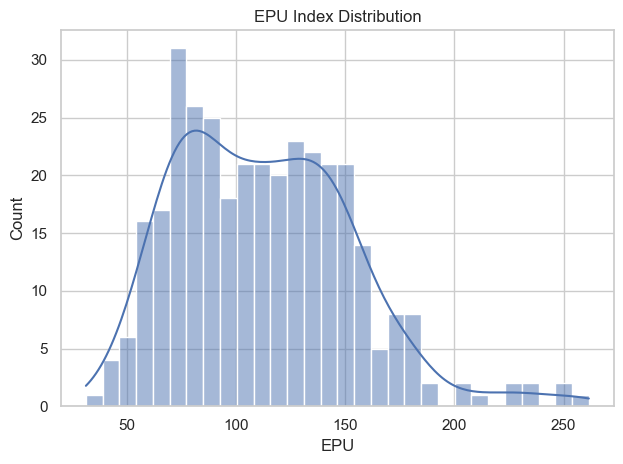

In [13]:
sns.histplot(
    eda['EPU'],
    bins=30,
    kde=True,
)

plt.title("EPU Index Distribution")
plt.tight_layout()
plt.show()


In general:
- Wide, multi-modal distribution with right-skew.
- Most values ~80–150 but some very high outliers.
- Suggests different regimes and crisis periods.
- Modeling should account for variability and outliers.

--- 
A box plot further illustrates the distribution's spread and highlights the presence of outliers. Most values lie below approximately 220, with clear outlier points beyond this threshold. These outliers reflect periods of exceptional economic policy uncertainty that could strongly influence forecasting models. Identifying and managing these points is essential in preprocessing and modeling phases.

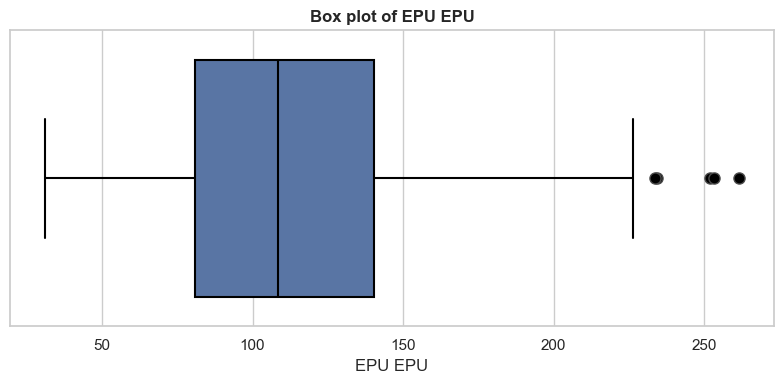

5th percentile: 58.21
10th percentile: 65.65
25th percentile: 80.98
50th percentile: 108.46
75th percentile: 140.23
90th percentile: 159.63
95th percentile: 177.71


In [14]:
plt.figure(figsize=(8, 4))
sns.boxplot(
    x=eda['EPU'],
    orient='h',
    boxprops=dict(edgecolor="black", linewidth=1.5),
    medianprops=dict(color='black', linewidth=1.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(markerfacecolor='black', marker='o', markersize=8, linestyle='none')
)

plt.title("Box plot of EPU EPU", fontweight='bold')
plt.xlabel("EPU EPU")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

percentiles = [5, 10, 25, 50, 75, 90, 95]
for p in percentiles:
    value = np.percentile(df['EPU'], p) 
    print(f"{p}th percentile: {value:.2f}")


**Why are there outliers in the Spain EPU Index?**

- They reflect real events (not noise).
- Driven by crises: 2008 Financial Crisis, Euro Debt Crisis, COVID-19, Ukraine-Russia War.
- Show sharp jumps in policy uncertainty during extreme shocks.
- Important signals for forecasting and risk analysis.

**With all the crise can be illustrated by the crisis chart and outliers point chart below**

---
We further annotate the time series with shaded bands for key crisis periods: the 2008 Financial Crisis, European Debt Crisis, COVID-19 Pandemic, and Ukraine-Russia War. These visual markers help link observed index spikes with real-world events. By mapping crises onto the index, we see clear patterns of heightened uncertainty during global and regional shocks. This context is vital for interpreting model forecasts and potential policy responses.

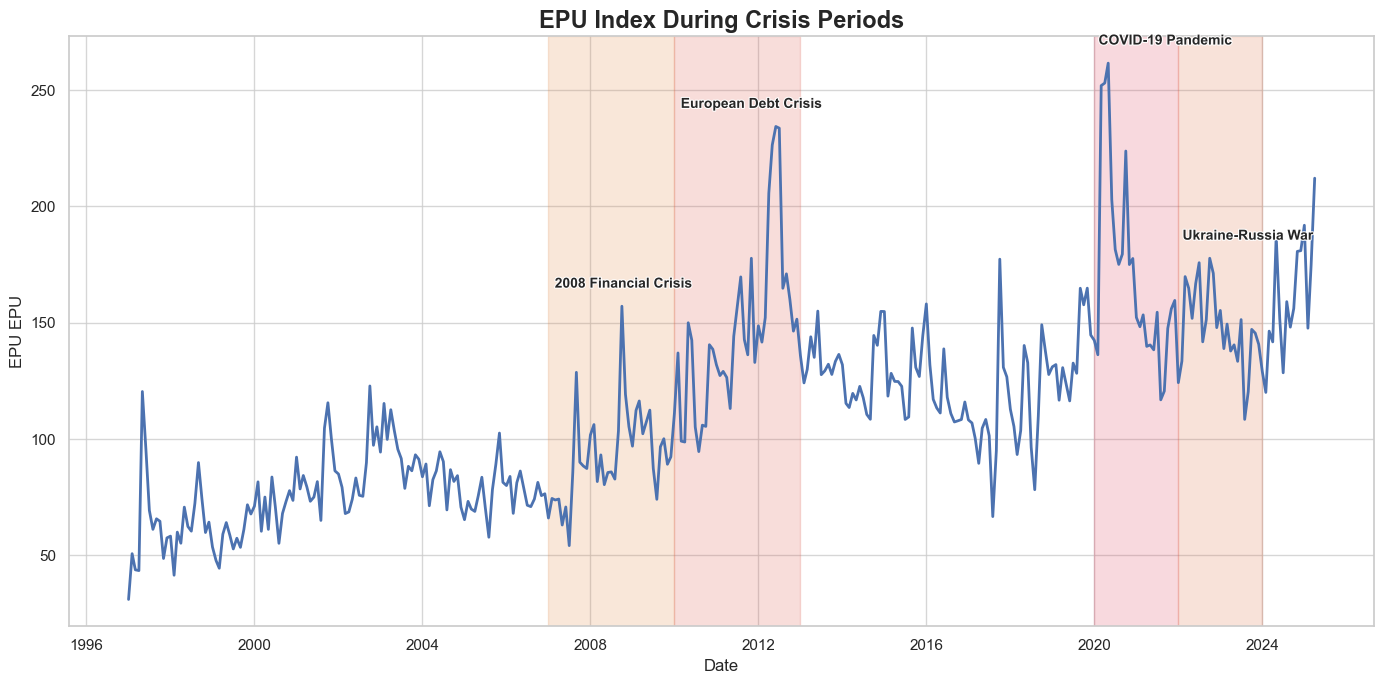

In [15]:
crisis_periods = {
    '2008 Financial Crisis': ('2007-01-01', '2009-12-31'),
    'European Debt Crisis': ('2010-01-01', '2012-12-31'),
    'COVID-19 Pandemic': ('2020-01-01', '2021-12-31'),
    'Ukraine-Russia War': ('2022-01-01', '2023-12-31')
}
highlight_colors = ["#e18745", "#dc574a", "#de425b", "#e06f45"]

plt.figure(figsize=(14, 7))


plt.plot(eda['Date'], eda['EPU'], linewidth=2,
         label="EPU Index", zorder=3)

for i, (crisis, (start, end)) in enumerate(crisis_periods.items()):
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    crisis_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    if not crisis_data.empty:
        plt.axvspan(
            start_date, end_date,
            color=highlight_colors[i],
            alpha=0.2,  
        )
        plt.text(
            x=start_date + (end_date - start_date) / 20,
            y=crisis_data['EPU'].max() + 8,
            s=crisis,
            fontsize=10,
            fontweight='bold',
            path_effects=[pe.withStroke(linewidth=1.5, foreground="white")]
        )
plt.title("EPU Index During Crisis Periods", fontsize=17, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("EPU EPU", fontsize=12)
plt.grid(alpha=0.8)
plt.tight_layout()
plt.show()


We explicitly identify outlier points above the upper interquartile threshold (using 1.5*IQR). Plotting these on the time series reveals that outliers correspond to major crisis periods. For example, spikes around 2012 and 2020 are visually highlighted, aligning with the European Debt Crisis and the COVID-19 Pandemic. This step is crucial in understanding model behavior and informing robust preprocessing strategies.

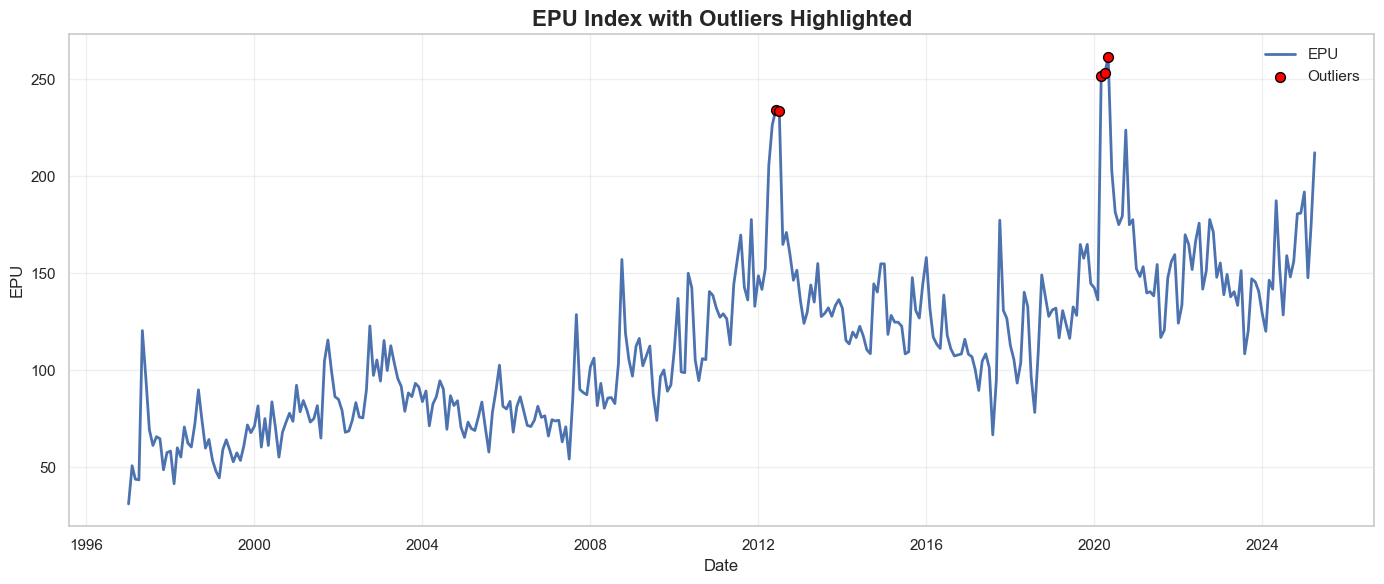

In [16]:
q1 = eda['EPU'].quantile(0.25)
q3 = eda['EPU'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr

outliers = eda[eda['EPU'] > upper]
plt.figure(figsize=(14, 6))
plt.plot(
    eda['Date'], eda['EPU'], linewidth=2, label='EPU'
)
plt.scatter(
    outliers['Date'], outliers['EPU'],
    color="red", edgecolor='black', s=50, zorder=4, label='Outliers'
)
plt.title('EPU Index with Outliers Highlighted', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('EPU')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


---
Also, a violin plot compares EPU Index distributions across decades. The 1990s and 2000s show tighter, lower-centered distributions, suggesting relatively stable and moderate uncertainty. In contrast, the 2010s and 2020s exhibit broader spreads and higher medians, reflecting increased uncertainty and more frequent extreme values. This progression underscores how Spain's economic policy environment has become more volatile over time, and it highlights the importance of using models capable of capturing these structural shifts.

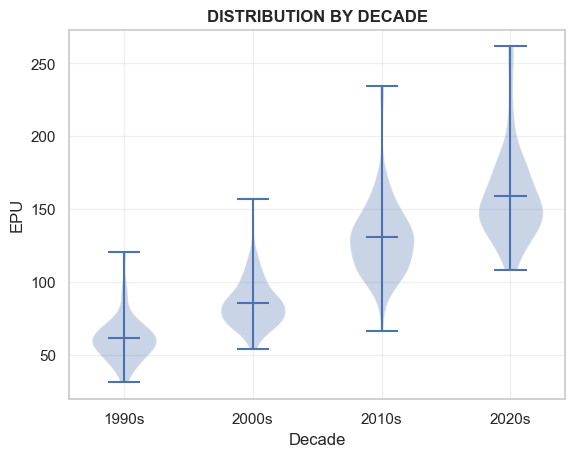

In [17]:
eda['Year'] = eda['Date'].dt.year
eda['Decade'] = (eda['Year'] // 10) * 10
decades = sorted(eda['Decade'].unique())
decade_data = [eda[eda['Decade'] == d]['EPU'] for d in decades]
violin_parts = plt.violinplot(decade_data, positions=range(len(decades)), showmeans=True)
plt.xticks(range(len(decades)))
plt.xticks(range(len(decades)), [f"{int(d)}s" for d in decades])
plt.title('DISTRIBUTION BY DECADE', fontweight='bold')
plt.xlabel('Decade')
plt.ylabel('EPU')
plt.grid(True, alpha=0.3)
plt.show();

To explore intra-year seasonality, we analyze average EPU EPUs by month. The bar chart reveals a clear pattern: uncertainty tends to be slightly lower during summer months like July and August, and higher during autumn, with October peaking at over 123 on average. This suggests that policy uncertainty in Spain is not uniformly distributed throughout the year but shows systematic seasonal variations. These cyclical effects can be important features for forecasting models, as they reflect regular economic rhythms tied to legislative cycles, budgeting periods, or business activity.

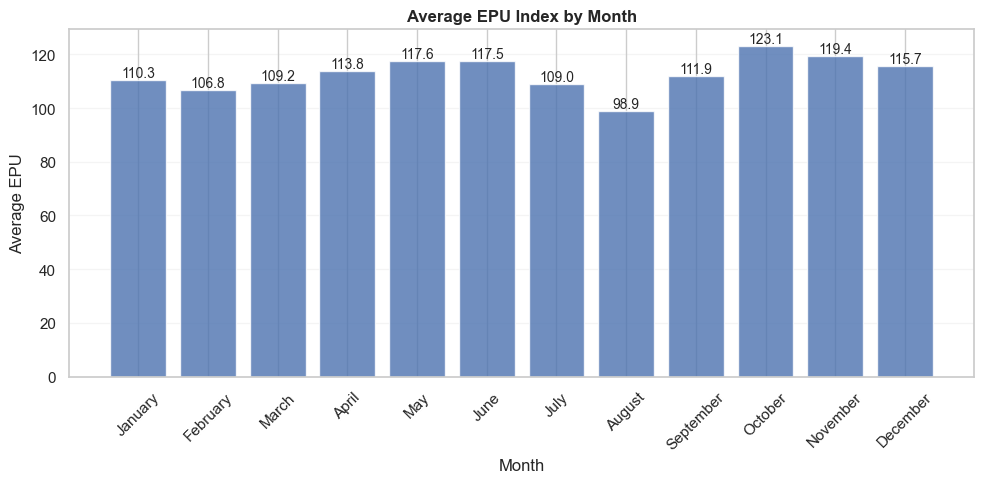

In [18]:
eda['Month'] = eda['Date'].dt.month
eda['Month_Name'] = eda['Date'].dt.month_name()

monthly_stats = eda.groupby('Month').agg(mean=('EPU', 'mean'), std=('EPU', 'std')).reset_index()
monthly_stats['Month_Name'] = pd.to_datetime(monthly_stats['Month'], format='%m').dt.month_name()

plt.figure(figsize=(10, 5))
bars = plt.bar(monthly_stats['Month_Name'], monthly_stats['mean'], alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.title('Average EPU Index by Month', fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Average EPU')
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha = 0.2)
plt.tight_layout()
plt.show()


---

After examining monthly seasonality, we turn to quarterly averages to confirm broader patterns in Spain's Economic Policy Uncertainty. The chart of average EPU Index by quarter reinforces our previous observations: Q3 consistently shows the lowest uncertainty (around 106), while Q4 peaks at nearly 120.

This seasonal behavior aligns with typical economic cycles—summer months (Q3) often see reduced political activity and fewer major announcements, while year-end (Q4) is marked by budget approvals and policy planning, heightening uncertainty. 

Recognizing these quarterly patterns is essential for modeling, as it captures systematic fluctuations that can improve forecast accuracy. Including quarterly seasonality terms or time-based dummy variables in statistical and machine learning models can help anticipate these predictable variations, reducing forecast error and supporting better decision-making for policymakers and businesses alike.


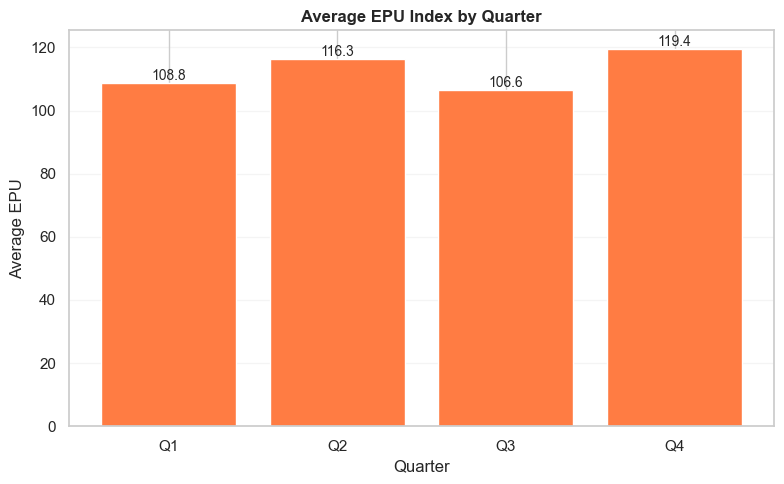

In [19]:
eda['Quarter'] = eda['Date'].dt.quarter
quarterly_stats = eda.groupby('Quarter')['EPU'].mean().reset_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(quarterly_stats['Quarter'], quarterly_stats['EPU'], color='#ff7c43')

# Annotate
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.title('Average EPU Index by Quarter', fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Average EPU')
plt.xticks([1, 2, 3, 4], ['Q1', 'Q2', 'Q3', 'Q4'])
plt.grid(True, axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

---

Following the year-over-year change analysis, the 12-month rolling volatility chart offers another key perspective on Spain's EPU Index. It shows periods of heightened uncertainty, especially during major crises like 2008, the European Debt Crisis, and COVID-19.

These spikes highlight not only increases in the index level but also in its variability—important for modeling since volatility can shift dramatically over time. This insight supports the use of models like ARCH/GARCH and justifies including rolling standard deviation as a feature to help capture changing risk and improve forecast robustness.

Together, this volatility view complements our earlier trend and seasonality analyses, giving us a more complete picture for effective predictive modeling.


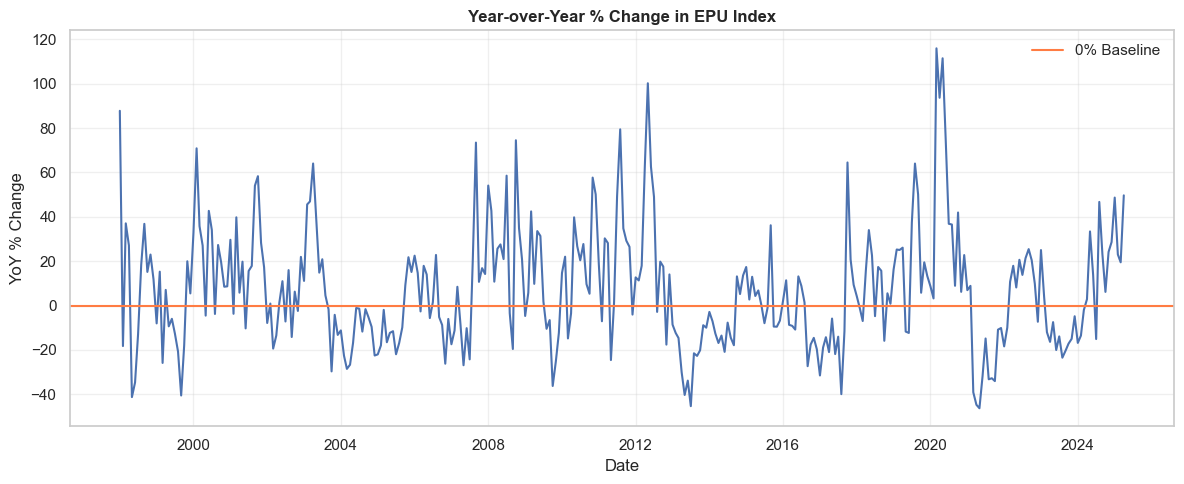

In [20]:
df_sorted = eda.sort_values(by='Date').copy()
df_sorted['YoY_Change'] = df_sorted['EPU'].pct_change(periods=12) * 100

plt.figure(figsize=(12, 5))
plt.plot(df_sorted['Date'], df_sorted['YoY_Change'], linewidth=1.5)
plt.axhline(0, color='#ff7c43', linestyle='-', label='0% Baseline')
plt.title('Year-over-Year % Change in EPU Index', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('YoY % Change')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


---

The 12-month rolling volatility chart refines our view of the EPU Index by tracking its changing variability over time. Noticeable peaks align with major crises, reinforcing the idea that uncertainty isn't constant but clustered in volatile periods.

This emphasizes the value of volatility features and models that can adapt to such shifts, supporting better forecasting and risk management.



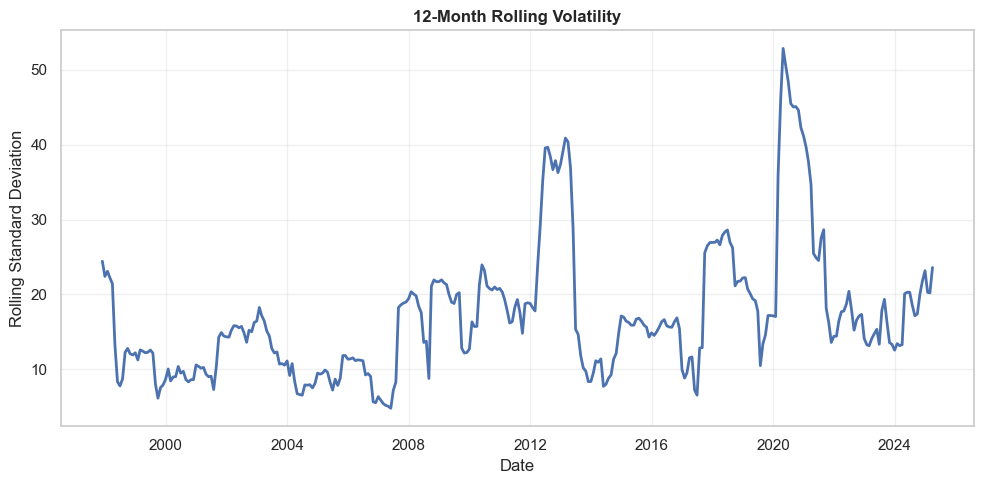

In [21]:
rolling_vol = eda.set_index('Date')['EPU'].rolling(window=12).std()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(rolling_vol.index, rolling_vol.values, linewidth=2)

ax.set_title('12-Month Rolling Volatility', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Rolling Standard Deviation')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


---

The heatmap shows strong autocorrelations for short-term lags like 1 and 2, as well as 6 and 12 months. These lags capture both immediate and seasonal dependencies, guiding feature selection for time series models.

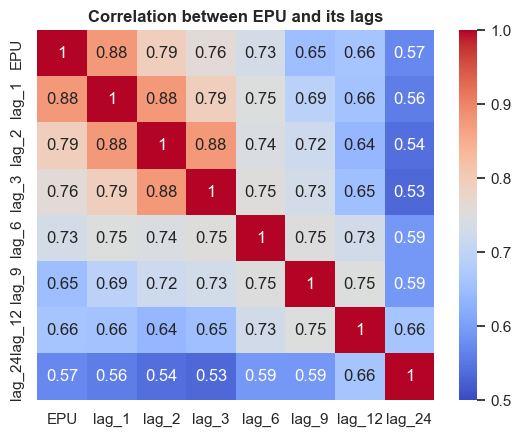

In [186]:
for lag in [1, 2, 3, 6, 9, 12, 24]:
    eda[f'lag_{lag}'] = eda['EPU'].shift(lag)
corr = eda[['EPU', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_9', 'lag_12', 'lag_24']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=0.5)
plt.title('Correlation between EPU and its lags', fontweight='bold')
plt.show()

---
This heatmap continues the story of strong seasonality seen in the monthly and quarterly bar charts. It shows monthly EPU values across years, highlighting not only crisis spikes but also recurring seasonal patterns. These visible monthly cycles reinforce why incorporating month as a feature or seasonal terms in models like SARIMA is crucial for capturing EPU's temporal dynamics.

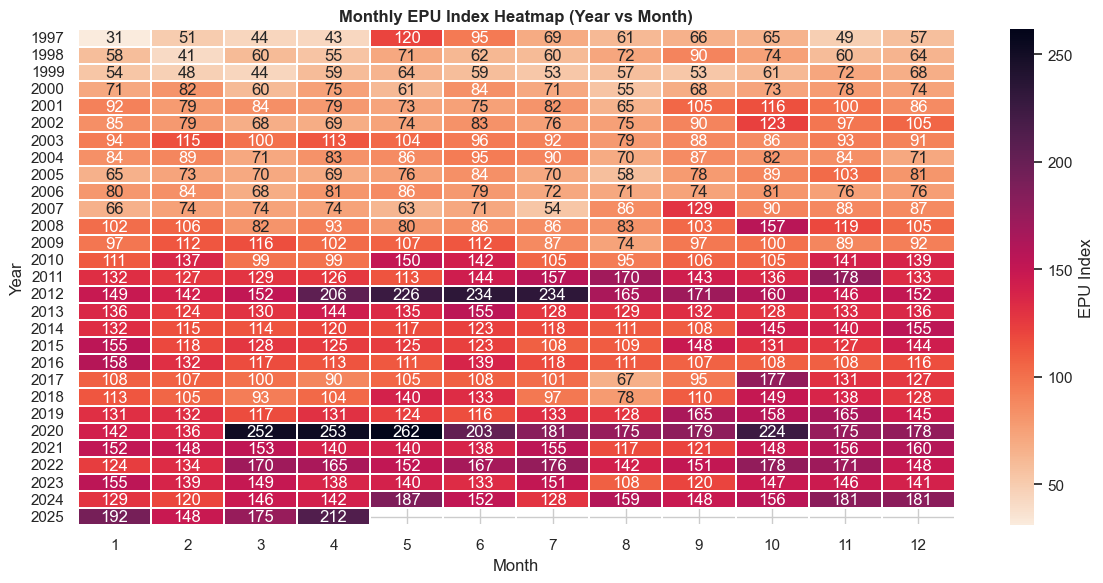

In [23]:
pivot = df.pivot_table(
    index=df['Date'].dt.year,
    columns=df['Date'].dt.month,
    values='EPU',
    aggfunc='mean'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap="rocket_r", annot=True, fmt=".0f", linewidths=0.3, cbar_kws={'label': 'EPU Index'})
plt.title("Monthly EPU Index Heatmap (Year vs Month)", fontweight='bold')
plt.xlabel("Month")
plt.ylabel("Year")
plt.tight_layout()
plt.show()


In [24]:
def check_stationarity(series, p_significant=0.05):
    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [25]:
check_stationarity(df["EPU"])

ADF Statistic : -1.52967, p-value: 0.51879
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
KPSS Statistic: 2.35393, p-value: 0.01000
Non-stationary


In [26]:
diff = df['EPU'].diff(1).dropna()

In [27]:
check_stationarity(diff)

ADF Statistic : -7.95110, p-value: 0.00000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571
KPSS Statistic: 0.12544, p-value: 0.10000
Stationary


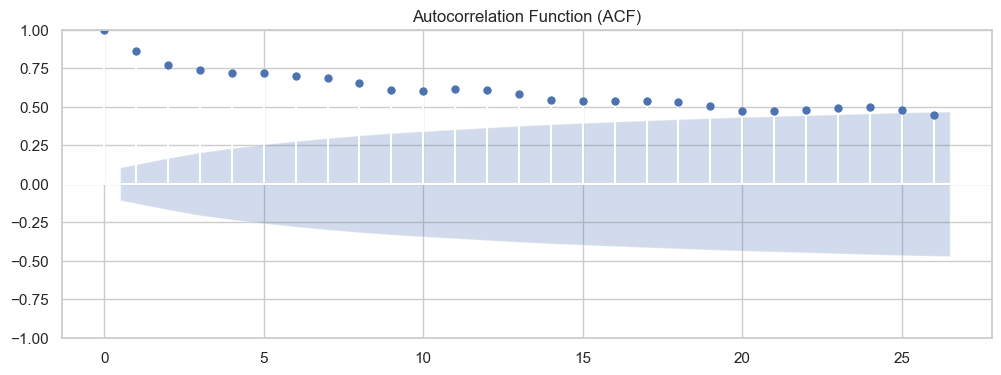

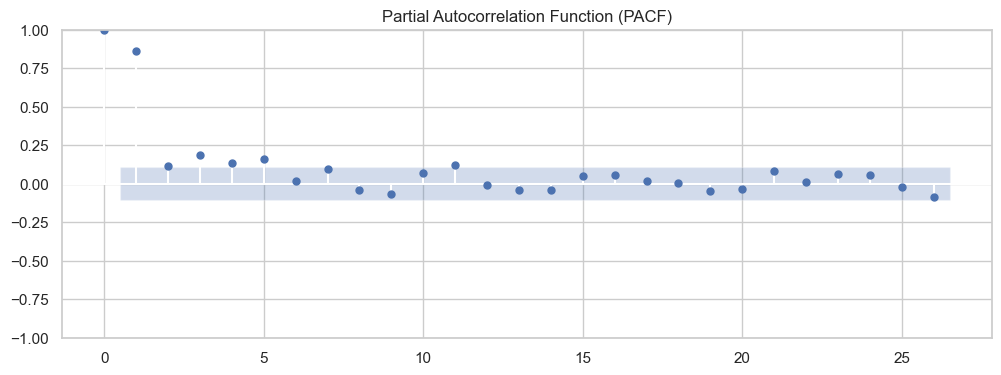

In [ ]:
# Plot the ACF
fig_acf = plot_acf(df['EPU'], title='Autocorrelation Function (ACF)')
fig_acf.set_size_inches(12,4)
plt.show()

# Plot the PACF
fig_pacf = plot_pacf(df['EPU'], title='Partial Autocorrelation Function (PACF)')
fig_pacf.set_size_inches(12,4)
plt.show()

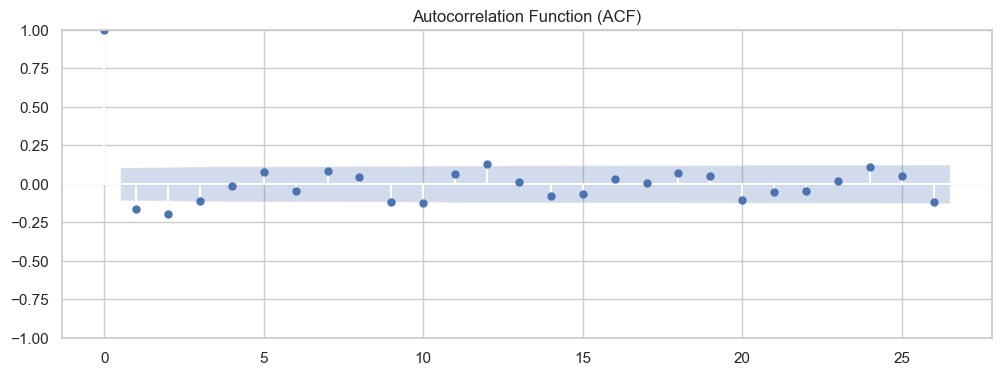

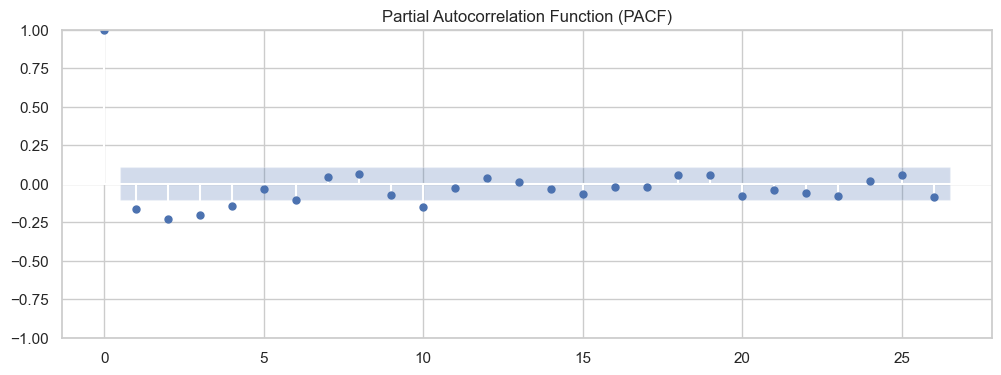

In [29]:
# Plot the ACF
fig_acf = plot_acf(diff, title='Autocorrelation Function (ACF)')
fig_acf.set_size_inches(12,4)
plt.show();

# Plot the PACF
fig_pacf = plot_pacf(diff, title='Partial Autocorrelation Function (PACF)')
fig_pacf.set_size_inches(12,4)
plt.show();


**ADF and KPSS Tests**:
  - The original EPU Index series is **non-stationary**, with clear trends and crisis-driven shifts.
  - After **first differencing**, it becomes **stationary** and shows no significant autocorrelation, making it suitable for ARIMA/SARIMA with d=1.

**ACF and PACF Analysis**:
  - Autocorrelations decline sharply after differencing.
  - No significant coefficients appear beyond lag 0, indicating a **random walk** behavior.
  - Confirms the first-differenced series is stationary and uncorrelated, simplifying choice of p and q.

**Conclusion**: These tests and plots ensure the series meets ARIMA/SARIMA assumptions, supporting more robust EPU Index forecasting.


### 3. DATA PREPROCESSING

In [30]:
df_sorted = df.sort_values('Date')
date_diff = df_sorted['Date'].diff().dt.days.dropna()

In [31]:
df['Month'] = df['Month'].astype(int)
df['EPU'] = df['EPU'].astype(float)

In [32]:
for col in df.columns:
    missing_data = df[col].isna().sum()
    missing_per = missing_data /len(df)*100
    print(f"Column {col} has {missing_per}% missing data")

Column Date has 0.0% missing data
Column Month has 0.0% missing data
Column EPU has 0.0% missing data


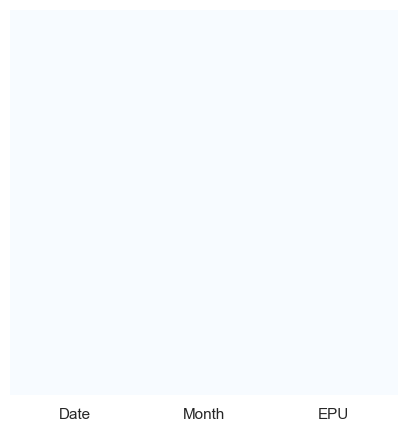

In [33]:
plt.figure(figsize = (5,5))
sns.heatmap(df.isna(), cbar = False, cmap = "Blues", yticklabels = False )
plt.show();

In [34]:
df.dropna(inplace=True)

In [35]:
test_size = 12
train = df[:-test_size]
test = df[-test_size:]
print(f"train size {train.shape}")
print(f"test size {test.shape}")

train size (328, 3)
test size (12, 3)


### 4. FEATURE ENGINEERING


**To improve forecasting accuracy, feature engineering transforms the raw EPU Index data into a richer set of predictive inputs. This step follows stationarity checks and outlier analysis, ensuring the data is well-prepared for modeling.**

fe_df includes:

Date: Monthly time index.

Month: Encodes seasonality patterns.

EPU: Original EPU Index.

Rolling Mean/Std (12 months): Captures long-term trend and volatility, essential for modeling uncertainty.

Lags (1, 2, 6, 12): Adds temporal dependencies identified via ACF/PACF analysis.

Fourier (FFT) features: Real and imaginary components of the series’ FFT, exposing deeper cyclical patterns beyond simple month effects.

Crisis dummies: Binary flags for known shock windows (e.g. 2007–09 Financial Crisis, European Debt Crisis, COVID-19, Ukraine–Russia War), so the model can immediately account for those extreme regimes.

These features help models learn seasonality, trend, volatility, autoregressive structure and known shocks—building on insights from stationarity tests and autocorrelation plots—to deliver more reliable EPU Index forecasts. Below is the code: 

In [36]:
class EPUFeaturePipeline:
    def __init__(
        self,
        target_column: str,
        date_column: str = 'Date',
        lags: list[int] = [1, 2, 6, 12],
        windows: list[int] = [3, 6, 12],
        shock_events: dict[str, tuple[str,str]] = {
            'crisis_2012': ('2012-06-01', '2012-07-31'),
            'covid_2020':  ('2020-03-01', '2020-05-31'),
        }
    ):
        self.target_column = target_column
        self.date_column   = date_column
        self.lags          = lags
        self.windows       = windows
        self.shock_events  = shock_events

    def run_pipeline(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        if self.date_column not in df.columns:
            df = df.reset_index()
        
        df = self._create_date_features(df)
        df = self._create_lag_features(df)
        df = self._create_rolling_features(df)
        df = self._create_fourier_features(df)
        df = self._create_shock_dummies(df)
        
        return df

    def _create_date_features(self, df: pd.DataFrame) -> pd.DataFrame:
        df[self.date_column] = pd.to_datetime(df[self.date_column])
        df['month']   = df[self.date_column].dt.month
        df['quarter'] = df[self.date_column].dt.quarter
        df['year']    = df[self.date_column].dt.year
        df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
        df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
        return df

    def _create_lag_features(self, df: pd.DataFrame) -> pd.DataFrame:
        for lag in self.lags:
            df[f'lag_{lag}'] = df[self.target_column].shift(lag)
        return df

    def _create_rolling_features(self, df: pd.DataFrame) -> pd.DataFrame:
        for w in self.windows:
            shifted = df[self.target_column].shift(1)
            df[f'roll_mean_{w}'] = shifted.rolling(window=w, min_periods=w).mean()
            df[f'roll_std_{w}']  = shifted.rolling(window=w, min_periods=w).std()
        return df

    def _create_fourier_features(self, df: pd.DataFrame) -> pd.DataFrame:
        vals = df[self.target_column].fillna(0).values
        ft   = fft(vals)
        df['fft_real'] = np.real(ft)
        df['fft_imag'] = np.imag(ft)
        return df

    def _create_shock_dummies(self, df: pd.DataFrame) -> pd.DataFrame:
        dates = df[self.date_column]
        for name, (start, end) in self.shock_events.items():
            mask = (dates >= pd.to_datetime(start)) & (dates <= pd.to_datetime(end))
            df[name] = mask.astype(int)
        return df


In [37]:
pipeline = EPUFeaturePipeline(target_column='EPU')
fe_df = pipeline.run_pipeline(df)

In [38]:
fe_df.head()

Date  Month         EPU  month  quarter  year  sin_month  \
0 1997-01-01      1   31.018169      1        1  1997   0.500000   
1 1997-02-01      2   50.695080      2        1  1997   0.866025   
2 1997-03-01      3   43.754341      3        1  1997   1.000000   
3 1997-04-01      4   43.427864      4        2  1997   0.866025   
4 1997-05-01      5  120.413849      5        2  1997   0.500000   

      cos_month      lag_1      lag_2  ...  roll_mean_3  roll_std_3  \
0  8.660254e-01        NaN        NaN  ...          NaN         NaN   
1  5.000000e-01  31.018169        NaN  ...          NaN         NaN   
2  6.123234e-17  50.695080  31.018169  ...          NaN         NaN   
3 -5.000000e-01  43.754341  50.695080  ...    41.822530    9.979685   
4 -8.660254e-01  43.427864  43.754341  ...    45.959095    4.104730   

   roll_mean_6  roll_std_6  roll_mean_12  roll_std_12      fft_real  \
0          NaN         NaN           NaN          NaN  38333.319786   
1          NaN         NaN           NaN          NaN   -848.930783   
2          NaN         NaN           NaN          NaN   1282.251094   
3          NaN         NaN           NaN          NaN  -2525.005739   
4          NaN         NaN           NaN          NaN    229.739352   

      fft_imag  crisis_2012  covid_2020  
0    -0.000000            0           0  
1  5946.762433            0           0  
2  2039.467416            0           0  
3  3287.850575            0           0  
4   188.672434            0           0  

[5 rows x 22 columns]

### 5. MODELLING

#### 5.1. BASELINE AND DECOMPOSITION

##### 5.1.1. TIME SERIES DECOMPOSITION

In [39]:
series = df["EPU"]

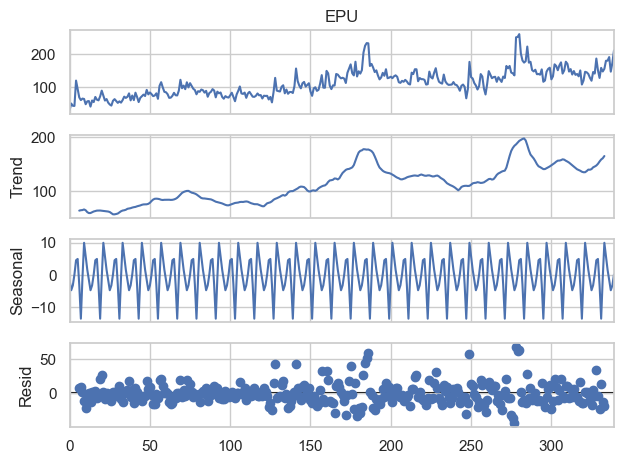

In [40]:
result_add = seasonal_decompose(series, model="additive", period=12)
result_add.plot();

**Additive** Seasonality component has roughly constant amplitude over time.

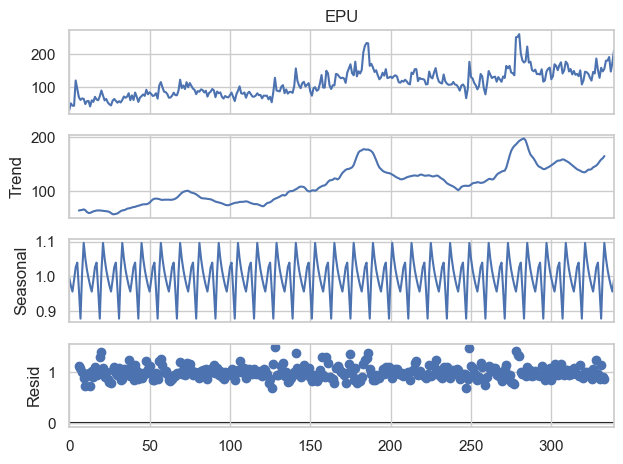

In [41]:
result_multi = seasonal_decompose(series, model="multiplicative", period=12)
result_multi.plot();

One the other hand, **Multiplicative**: seasonality scales with the overall level of the index.

-> Hence: we conclude that 

In [42]:
seasonal_add = result_add.seasonal
seasonal_multi = result_multi.seasonal
trend_add = result_add.trend
trend_multi = result_multi.trend

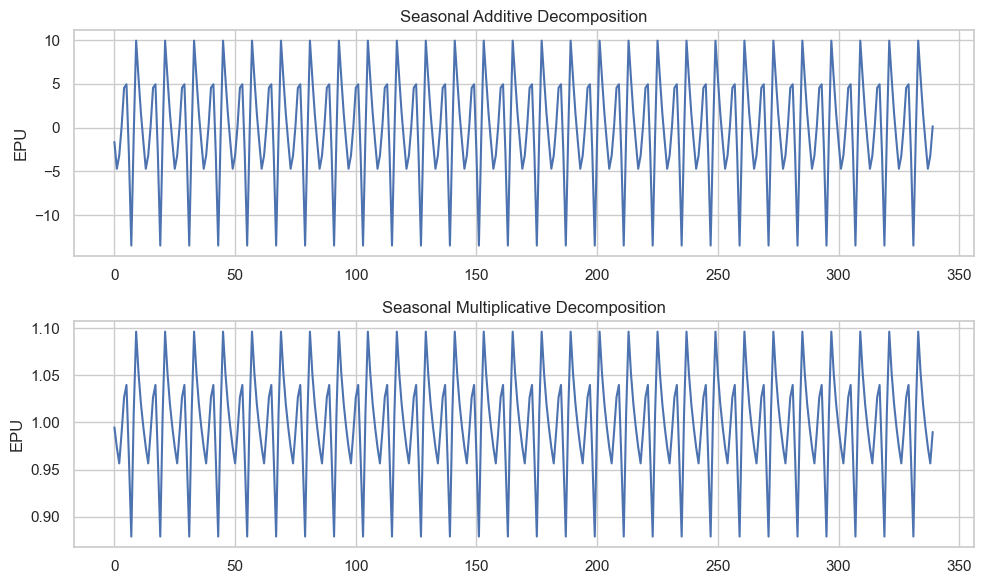

In [43]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(seasonal_add)
axs[0].set_title('Seasonal Additive Decomposition')
axs[0].set_ylabel('EPU')
axs[0].grid(True)

axs[1].plot(seasonal_multi)
axs[1].set_title('Seasonal Multiplicative Decomposition')
axs[1].set_ylabel('EPU')
axs[1].grid(True)

plt.tight_layout()

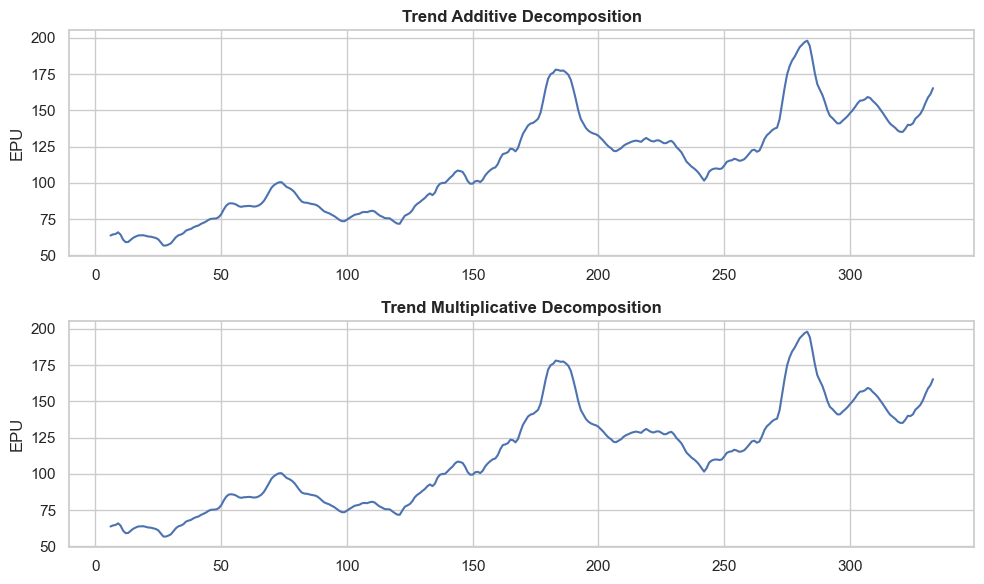

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(trend_add)
axs[0].set_title('Trend Additive Decomposition', fontweight='bold')
axs[0].set_ylabel('EPU')
axs[0].grid(True)

axs[1].plot(trend_multi)
axs[1].set_title('Trend Multiplicative Decomposition', fontweight='bold')
axs[1].set_ylabel('EPU')
axs[1].grid(True)

plt.tight_layout()

Comparing the seasonal components, the additive model shows constant-amplitude seasonality around zero, failing to reflect scale changes in the series. The multiplicative decomposition scales the seasonal effect proportionally with the trend, capturing the real structure of the EPU Index which exhibits larger seasonal swings at higher levels. Therefore, the multiplicative decomposition is better suited for this data.

---


##### 5.1.2. STL FORECASTING

In [45]:
df['Date'] = pd.to_datetime(df['Date'])
series = df.set_index('Date')['EPU'].asfreq('MS').interpolate()
train_data = series[:-12]
test_data = series[-12:]
print(train_data.shape, test_data.shape)

(328,) (12,)


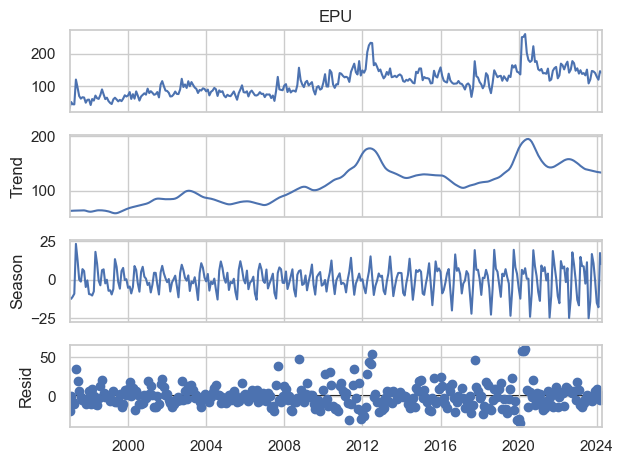

In [46]:
stl = STL(train_data, seasonal=13)
result = stl.fit()
result.plot()
plt.show()

In [47]:
deseasonalized = train_data - result.seasonal

In [48]:
model = auto_arima(deseasonalized, seasonal=False, suppress_warnings=True, stepwise=True, trace=False)
model.fit(deseasonalized)
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  328
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1357.342
Date:                Tue, 01 Jul 2025   AIC                           2720.684
Time:                        17:29:31   BIC                           2732.054
Sample:                    01-01-1997   HQIC                          2725.221
                         - 04-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5763      0.080      7.202      0.000       0.419       0.733
ma.L1         -0.8447      0.052    -16.160      0.000      -0.947      -0.742
sigma2       235.7782      9.563     24.655      0.0

In [49]:
forecast_deseasonal = model.predict(n_periods=12)

In [50]:
def forecast_seasonal_component(result, steps, seasonal_period):
    seasonal_component = np.tile(result.seasonal[-seasonal_period:], steps // seasonal_period)
    if steps % seasonal_period:
        seasonal_component = np.concatenate([seasonal_component, result.seasonal[-seasonal_period: -seasonal_period + steps % seasonal_period]])
    return seasonal_component[:steps]

seasonal_forecast = forecast_seasonal_component(result, 12, 12)

In [51]:
final_forecast = forecast_deseasonal + seasonal_forecast
final_forecast = pd.Series(final_forecast, index=test_data.index, name='Forecast')

mae_test = mean_absolute_error(test_data, final_forecast)
rmse_test = np.sqrt(mean_squared_error(test_data, final_forecast))
mse_test = mean_squared_error(test_data, final_forecast)
mape_test = mean_absolute_percentage_error(test_data, final_forecast)

print(f"RMSE : {rmse_test:.2f}")
print(f"MSE  : {mse_test:.2f}")
print(f"MAE  : {mae_test:.2f}")
print(f"MAPE : {mape_test:.2f}")



RMSE : 40.77
MSE  : 1661.91
MAE  : 35.93
MAPE : 0.21


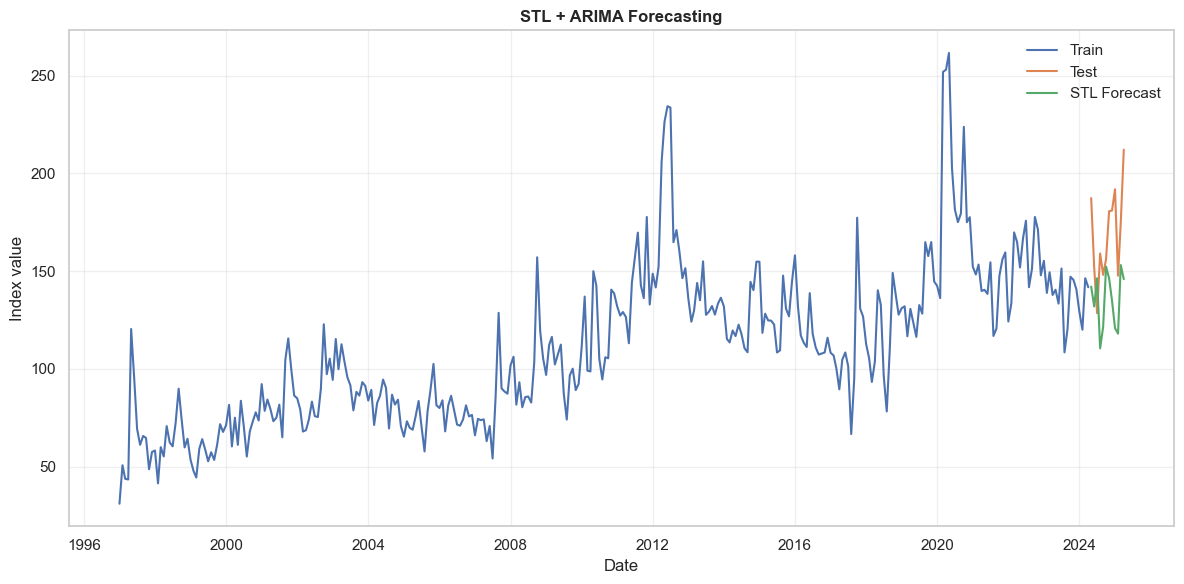

In [52]:
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(final_forecast.index, final_forecast, label='STL Forecast')
plt.title('STL + ARIMA Forecasting', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Index value')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



##### 5.1.3. MOVING AVERAGE

Plot the original EPU Index with 3-, 6-, and 12-month moving averages. Shorter windows smooth minor noise while preserving short-term shifts. The 12-month average clearly shows the long-term upward trend, especially around crises, confirming persistent increases in baseline uncertainty over time.

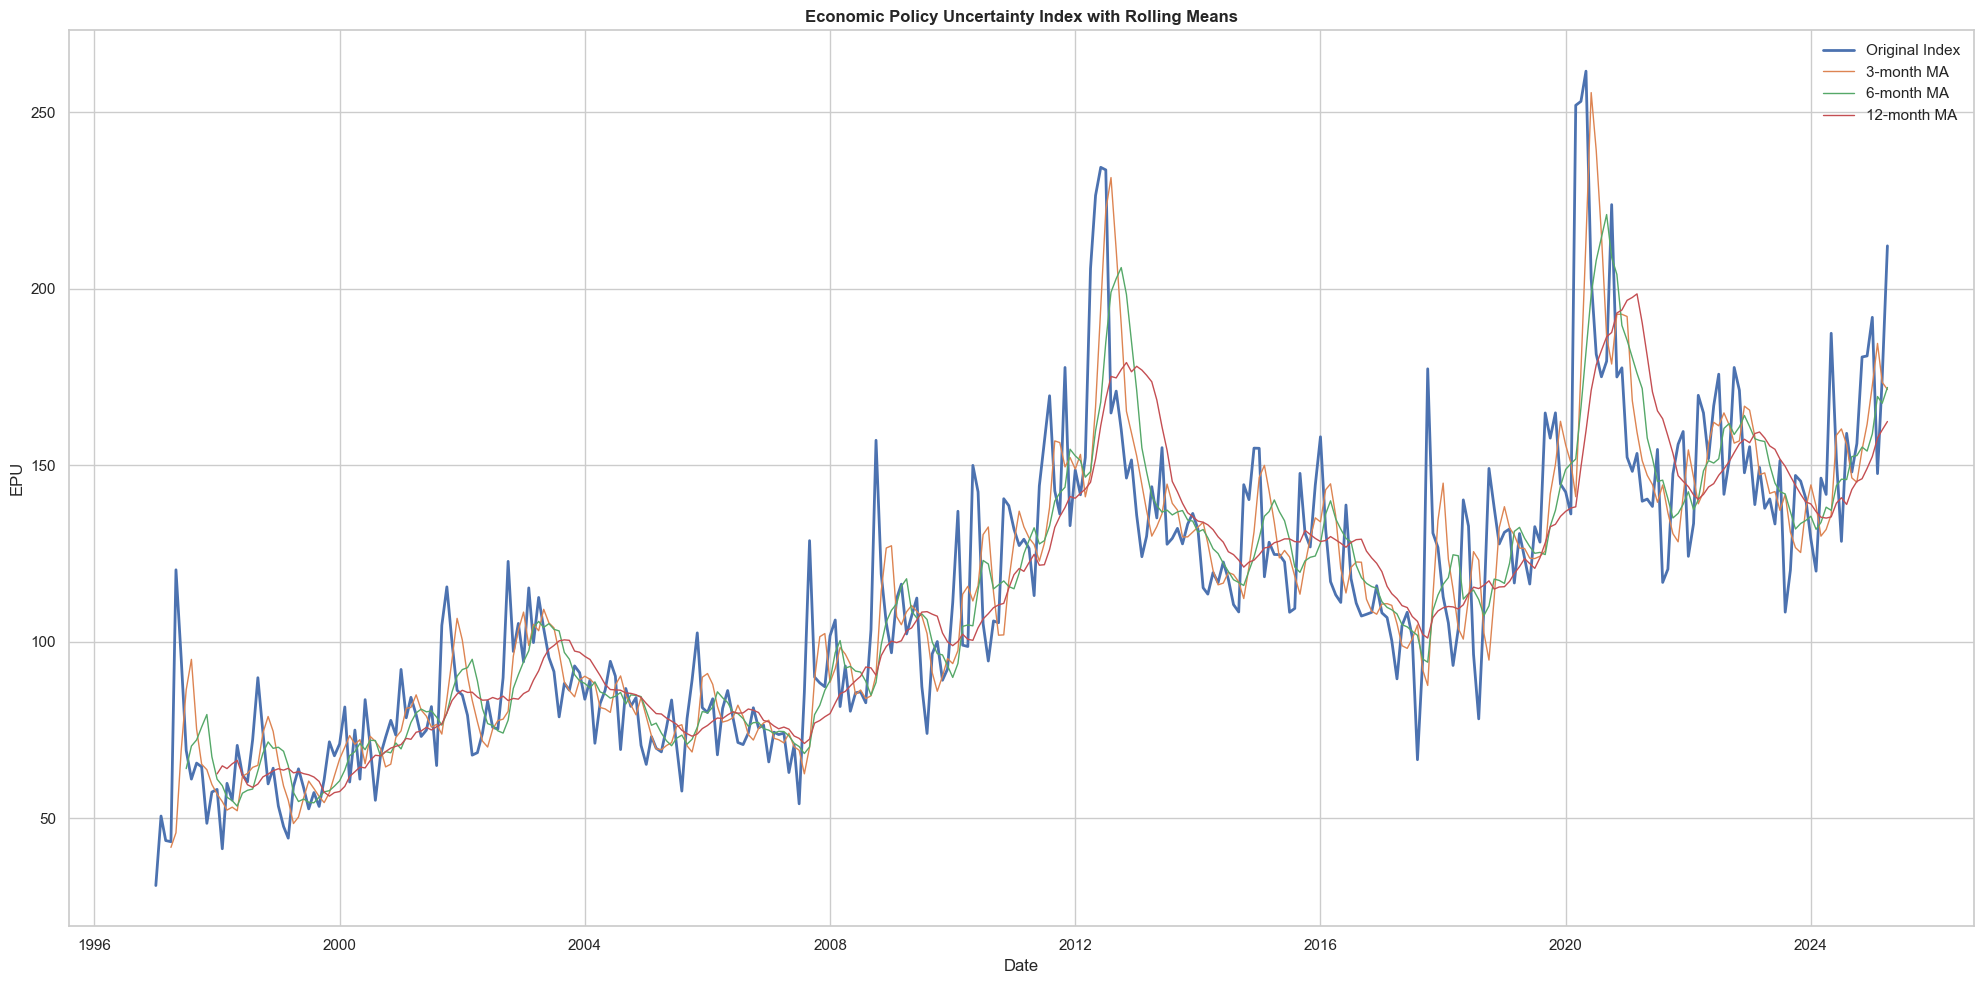

In [53]:
plt.figure(figsize=(20, 10))
plt.plot(fe_df['Date'], fe_df['EPU'], label='Original Index', linewidth=2)
plt.plot(fe_df['Date'], fe_df['roll_mean_3'], label='3-month MA', linewidth=1)
plt.plot(fe_df['Date'], fe_df['roll_mean_6'], label='6-month MA', linewidth=1)
plt.plot(fe_df['Date'], fe_df['roll_mean_12'], label='12-month MA', linewidth=1)
plt.xlabel('Date')
plt.ylabel('EPU')
plt.title('Economic Policy Uncertainty Index with Rolling Means', fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
n_test = 12
train, test = fe_df['EPU'][:-n_test], fe_df['EPU'][-n_test:]
dates_test   = fe_df['Date'][-n_test:]
print(train.shape, test.shape, dates_test.shape)

(328,) (12,) (12,)


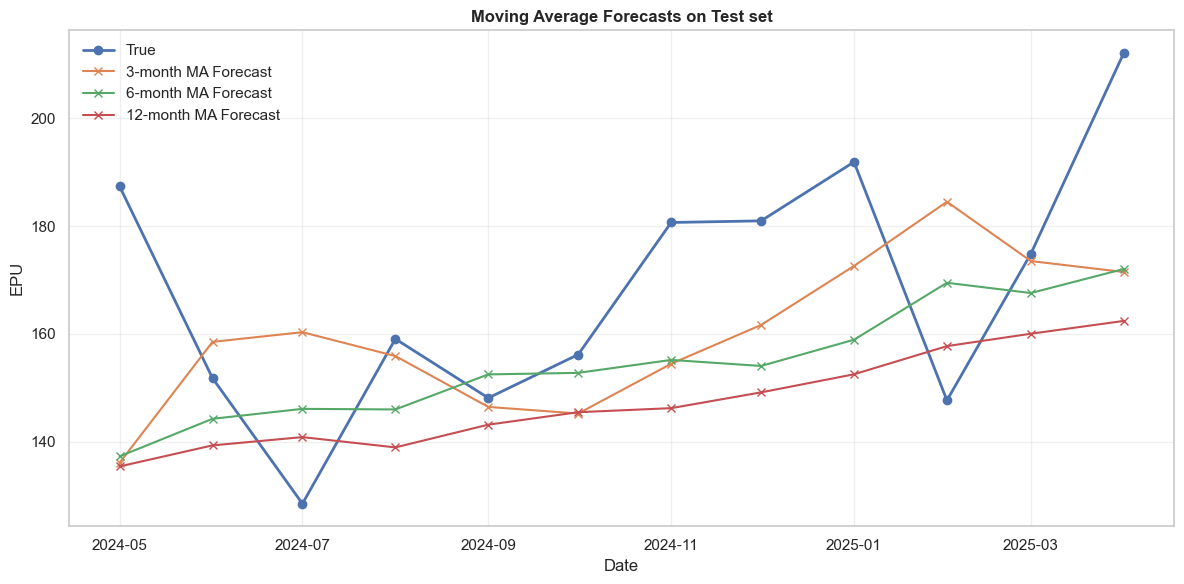

In [55]:
windows = [3, 6, 12]
preds_dict = {} 

for w in windows:
    preds = [
        fe_df['EPU'].iloc[max(0, i-w):i].mean()
        for i in range(len(train), len(train)+len(test))
    ]
    preds_dict[w] = preds

plt.figure(figsize=(12, 6))
plt.plot(dates_test, test.values, marker='o', label='True', linewidth=2)
for w in windows:
    plt.plot(dates_test, preds_dict[w], marker='x', label=f'{w}-month MA Forecast')
plt.title('Moving Average Forecasts on Test set', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('EPU')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
results = []
y_true = test.values
for w in [3, 6, 12]:
    
    preds = [fe_df['EPU'].iloc[max(0,i-w):i].mean()
             for i in range(len(train), len(train)+len(test))]
    y_pred = np.array(preds)

    # metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    results.append({'window': w, 'RMSE' : rmse ,'MSE': mse, 'MAE': mae, 'MAPE (%)': mape})

metrics_df = pd.DataFrame(results).set_index('window')
print('Moving average metrics:')
print(metrics_df)



Moving average metrics:
             RMSE         MSE        MAE   MAPE (%)
window                                             
3       26.261687  689.676216  20.788323  12.243745
6       25.308002  640.494979  20.902687  11.904563
12      29.024490  842.421013  24.419754  13.702740


Assess simple moving average forecasts using 3-, 6-, and 12-month windows on the test set. Results show low MAPE values around 12–14%, with shorter windows (3, 6 months) performing slightly better overall. This confirms that even basic smoothing can provide reasonable short-term forecasts but also highlights the need for more advanced models to capture complex trends and crisis-driven spikes.

---

#### 5.2. SMOOTHING MODELS

##### 5.2.1. SINGLE EXPONENTIAL SMOOTHING

Single Exponential Smoothing (SES) is a simple time series forecasting method that assigns exponentially decreasing weights to past observations. This approach is well-suited for series without strong trend or seasonal components, offering a way to smooth out short-term fluctuations while preserving the general level of the series.

In [57]:
n = len(series)
split_idx = -12
train, test = series.iloc[:split_idx], series.iloc[split_idx:]
print(train.shape, test.shape)

(328,) (12,)


In [58]:
model = SimpleExpSmoothing(train).fit(optimized=True)
alpha = model.params['smoothing_level']
print(f"Optimal Smoothing Level (alpha): {alpha:.3f}")

Optimal Smoothing Level (alpha): 0.650


In [59]:
forecast = model.forecast(len(test))

mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print(f"SES Test MSE  : {mse:.2f}")
print(f"SES Test RMSE : {rmse:.2f}")
print(f"SES Test MAE  : {mae:.2f}")
print(f"SES Test MAPE : {mape:.2f}%")

SES Test MSE  : 1269.31
SES Test RMSE : 35.63
SES Test MAE  : 29.59
SES Test MAPE : 16.42%


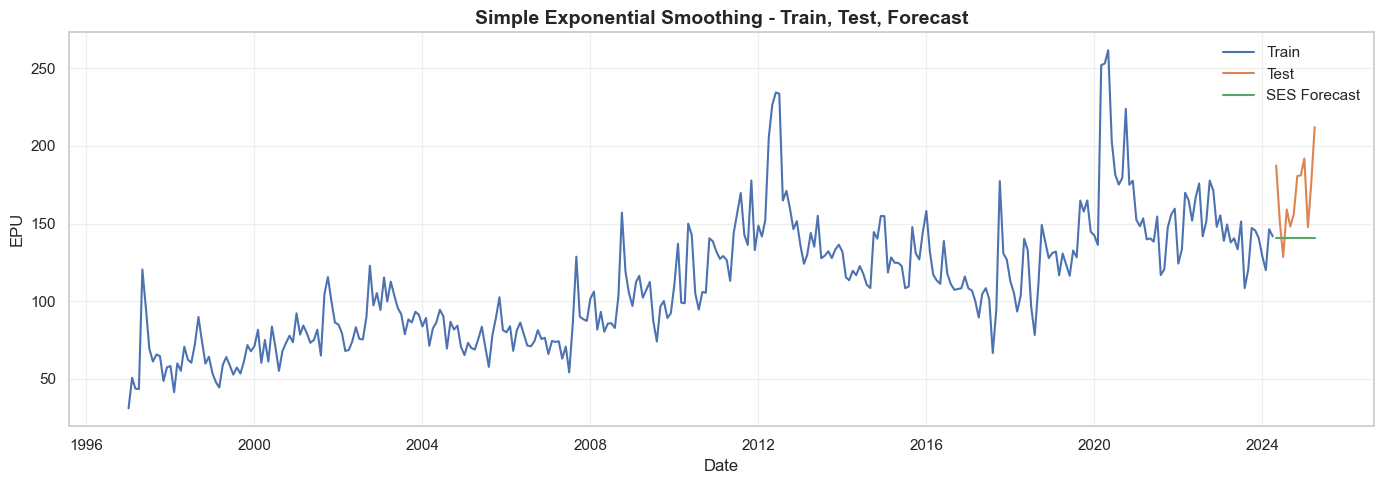

In [60]:
plt.figure(figsize=(14, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='SES Forecast')
plt.title('Simple Exponential Smoothing - Train, Test, Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('EPU')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Applying Simple Exponential Smoothing yields a single flat forecast line across the test period. While this approach smooths short-term noise and identifies the overall level of the series, it fails to capture the pronounced trend and strong seasonal patterns present in the EPU Index. This limitation suggests the need for more advanced methods, such as Holt-Winter linear or Holt-Winters seasonal models, which explicitly model trend and seasonality for improved forecasting accuracy.

##### 5.2.2. HOLT'S WINTER LINEAR TREND

In [61]:
holt_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
holt_forecast = holt_model.forecast(len(test))

In [62]:
mse_holt  = mean_squared_error(test, holt_forecast)
rmse_holt = np.sqrt(mse_holt)
mae_holt  = mean_absolute_error(test, holt_forecast)
mape_holt = np.mean(np.abs((test - holt_forecast) / test)) * 100  # (%)

print(f"Holt Linear Trend Test MSE : {mse_holt:.3f}")
print(f"Holt Linear Trend Test RMSE: {rmse_holt:.3f}")
print(f"Holt Linear Trend Test MAE : {mae_holt:.3f}")
print(f"Holt Linear Trend Test MAPE: {mape_holt:.2f}%")


Holt Linear Trend Test MSE : 1204.195
Holt Linear Trend Test RMSE: 34.702
Holt Linear Trend Test MAE : 28.659
Holt Linear Trend Test MAPE: 15.89%


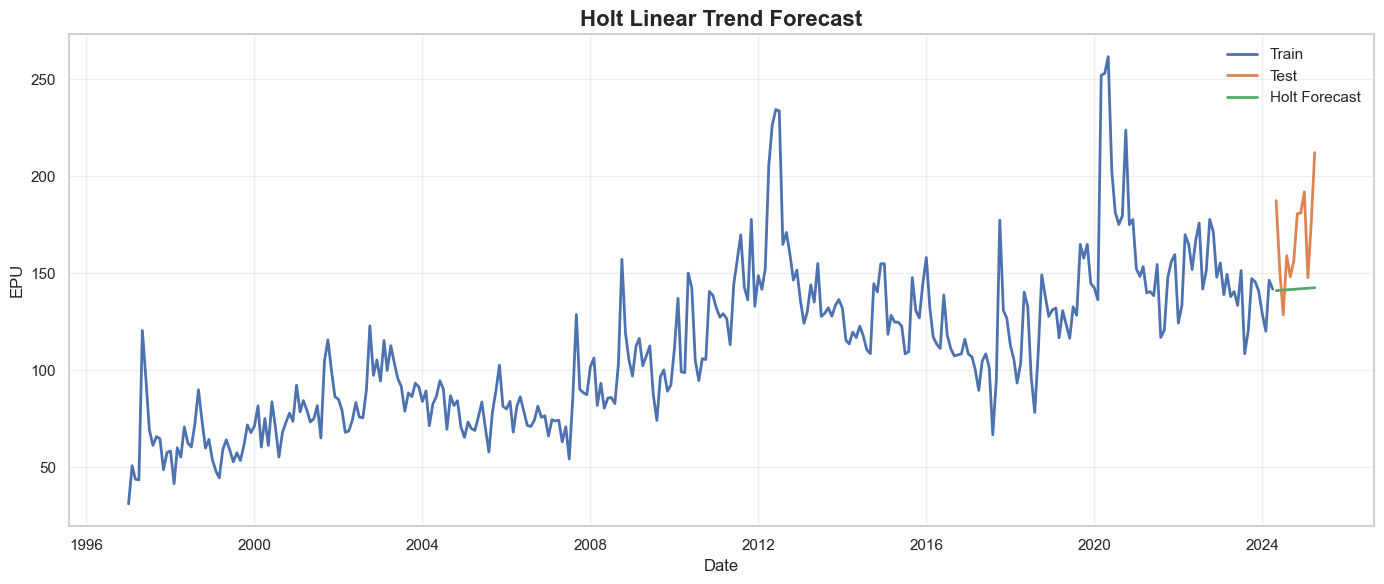

In [63]:
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train', linewidth=2)
plt.plot(test.index, test, label='Test', linewidth=2)
plt.plot(test.index, holt_forecast, linestyle='-', label='Holt Forecast', linewidth=2)

plt.title('Holt Linear Trend Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('EPU')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The Holt linear trend model captures the overall upward movement but fails to reflect the clear seasonal patterns in the EPU Index. To address this limitation, models with explicit seasonality such as Holt-Winters should be considered for improved forecasting accuracy.

##### 5.2.3. HOLT'S WINTER SEASONAL

In [64]:
hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='mul', 
    seasonal_periods=12
).fit()

In [65]:
hw_forecast = hw_model.forecast(len(test))

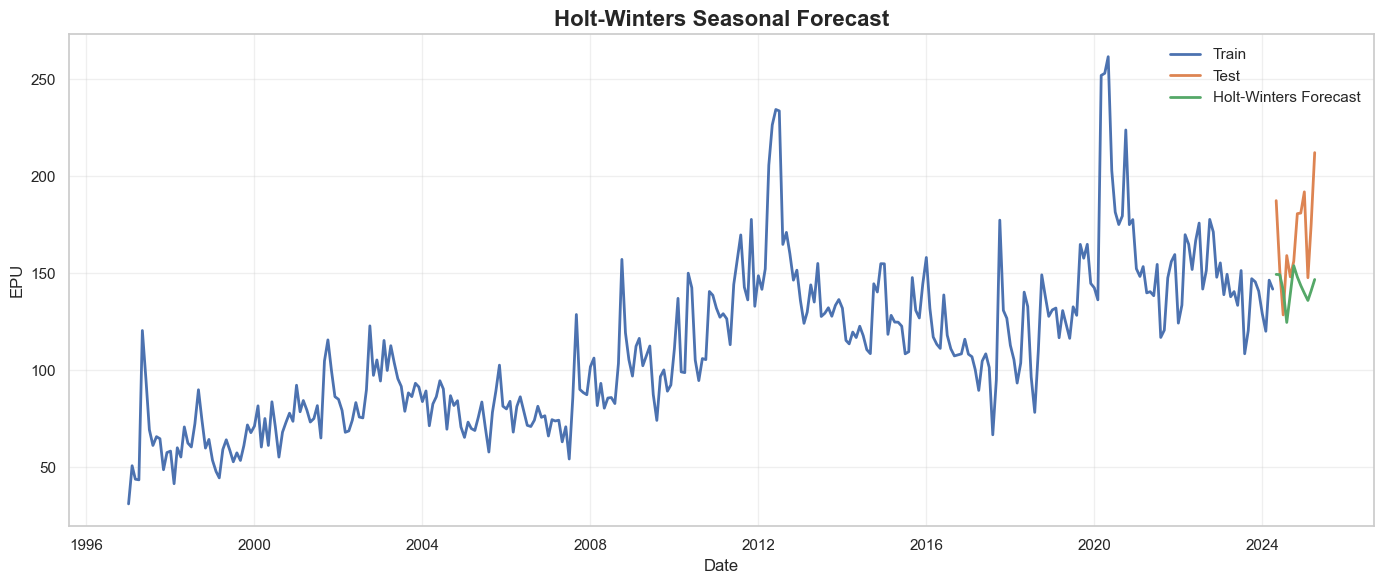

In [66]:
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train', linewidth=2)
plt.plot(test.index, test, label='Test', linewidth=2)
plt.plot(test.index, hw_forecast, linestyle='-', label='Holt-Winters Forecast', linewidth=2)

plt.title('Holt-Winters Seasonal Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('EPU')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [67]:
mse_hw  = mean_squared_error(test, hw_forecast)
rmse_hw = np.sqrt(mse_hw)
mae_hw  = mean_absolute_error(test, hw_forecast)
mape_hw = np.mean(np.abs((test - hw_forecast) / test)) * 100   # (%)  

print(f"Holt-Winters Test MSE : {mse_hw:.3f}")
print(f"Holt-Winters Test RMSE: {rmse_hw:.3f}")
print(f"Holt-Winters Test MAE : {mae_hw:.3f}")
print(f"Holt-Winters Test MAPE: {mape_hw:.2f}%")


Holt-Winters Test MSE : 1137.737
Holt-Winters Test RMSE: 33.730
Holt-Winters Test MAE : 27.701
Holt-Winters Test MAPE: 15.44%


The Holt-Winters seasonal model incorporates both trend and seasonality, producing forecasts that better align with the observed cyclical patterns in the EPU Index. The forecast curve more closely follows the test data, capturing seasonal fluctuations and level shifts more effectively than simpler smoothing approaches.

However, while this method improves predictive accuracy by modeling trend and seasonality explicitly, limitations remain in fully capturing sharp crisis-driven spikes and changing volatility. To address these challenges, exploring more flexible models—such as SARIMA, Prophet, or machine learning approaches—may help achieve more robust and accurate forecasts.

#### 5.3. CLASSICAL TIME SERIES MODELS

##### 5.3.1. ARIMA

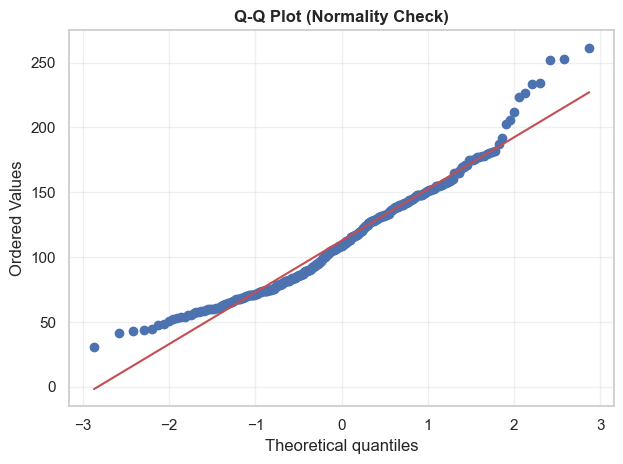

In [68]:
stats.probplot(df['EPU'], dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [69]:
auto_arima_model = pm.auto_arima(
    df["EPU"],
    start_p=0, max_p=5,         
    d=1,                        
    start_q=0, max_q=5,        
    seasonal=False,          
    information_criterion='aic',
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


print(auto_arima_model.summary())
best_order_arima = auto_arima_model.order
print("Best ARIMA order:", best_order_arima)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2996.551, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2989.565, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2978.704, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2994.793, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2951.292, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2949.811, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2972.669, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2951.598, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2951.716, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2950.244, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2960.258, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2953.295, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2949.003, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2950.870, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]          

In [70]:
model_arima = ARIMA(df["EPU"], order=(2, 1, 1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    EPU   No. Observations:                  340
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1470.502
Date:                Tue, 01 Jul 2025   AIC                           2949.003
Time:                        17:29:36   BIC                           2964.307
Sample:                             0   HQIC                          2955.102
                                - 340                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4600      0.085      5.430      0.000       0.294       0.626
ar.L2         -0.1380      0.057     -2.433      0.015      -0.249      -0.027
ma.L1         -0.7556      0.071    -10.702      0.0

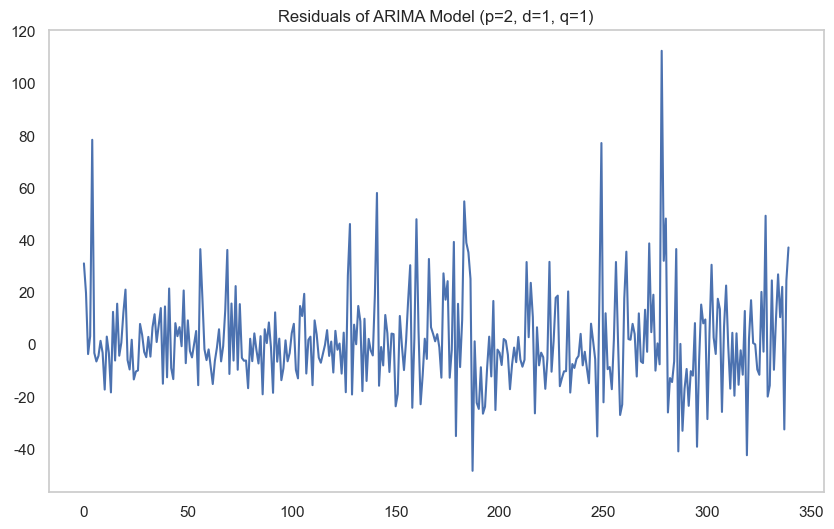

In [71]:
# Residual analysis
residuals = model_arima_fit.resid
plt.figure(figsize=(10, 6))

# Format y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{int(x):,}'))

plt.plot(residuals)
plt.title('Residuals of ARIMA Model (p=2, d=1, q=1)')
plt.grid()
plt.show()

Residuals oscillate around zero – this is good, showing the model captured the main trend. However, cannot explain the outliers and volatility

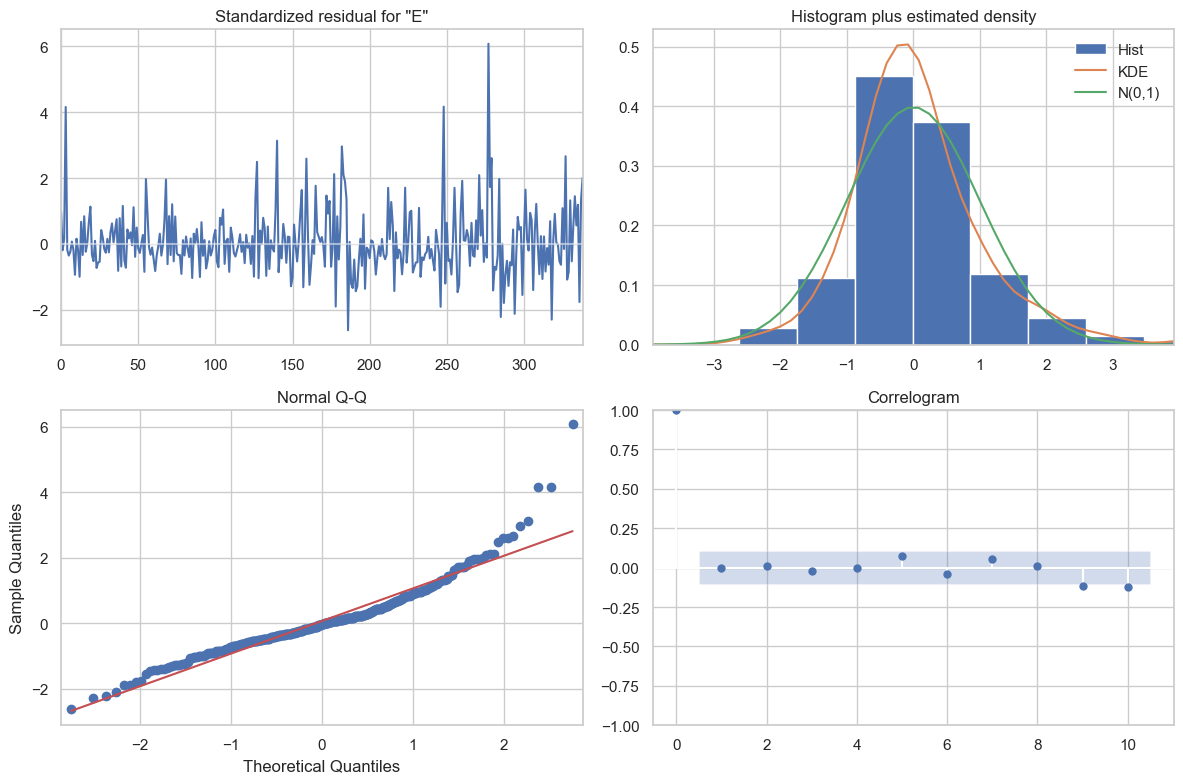

In [72]:
fc = model_arima_fit.get_forecast(steps=12)
y_pred = fc.predicted_mean
conf_int = fc.conf_int()
model_arima_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

Histogram + KDE: approximately normal (mean ~ 0), but with asymmetric tails. <br>
Q-Q plot: slight deviation in the extremes. <br>
Correlogram: lags within confidence intervals -> residuals are approximately white noise.

In [73]:
order = (2, 1, 1)  
y = df["EPU"]
train, test = y.iloc[:-12], y.iloc[-12:]
h = len(test)
print(train.shape, test.shape)

(328,) (12,)


In [74]:
model = ARIMA(train, order=order).fit()
y_pred = model.forecast(steps=h)  
y_pred = pd.Series(y_pred.values, index=test.index)

In [75]:
mse_arima  = mean_squared_error(test, y_pred)           
rmse_arima = np.sqrt(mse_arima)                          
mae_arima  = mean_absolute_error(test, y_pred)          
mape_arima = np.mean(np.abs((test - y_pred) / test)) * 100  

print(f"ARIMA Test MSE  : {mse_arima:.3f}")
print(f"ARIMA Test RMSE : {rmse_arima:.3f}")
print(f"ARIMA Test MAE  : {mae_arima:.3f}")
print(f"ARIMA Test MAPE : {mape_arima:.2f}%")

ARIMA Test MSE  : 1450.032
ARIMA Test RMSE : 38.079
ARIMA Test MAE  : 32.199
ARIMA Test MAPE : 17.91%


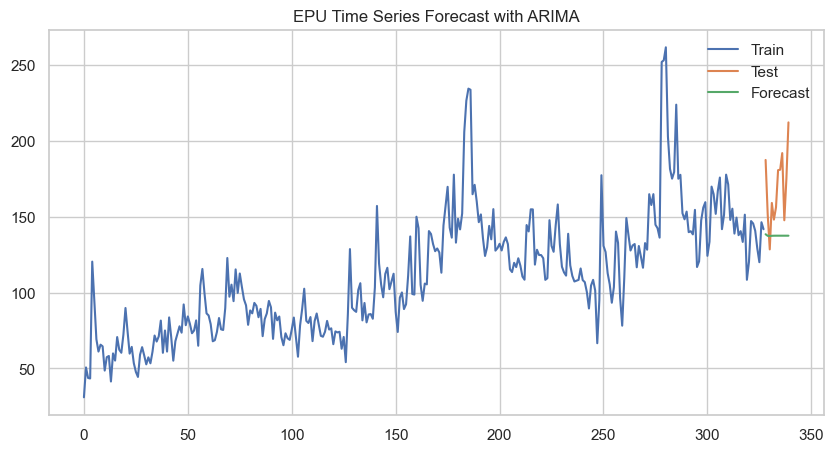

In [76]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test,   label='Test')
plt.plot(y_pred.index, y_pred, label='Forecast')
plt.title('EPU Time Series Forecast with ARIMA')
plt.legend()
plt.show()

 ARIMA handles smooth trends well but struggles with high volatility or structural breaks, ARIMA cleaned the autocorrelation well, but to forecast EPU Index more accurately—especially during volatile periods, hence we should try SARIMA and SARIMAX with exogenous features

##### 5.3.2. SARIMA

To incorporate seasonal effects in time series forecasting, we use the **SARIMA** model (Seasonal ARIMA). Unlike the basic ARIMA, SARIMA adds parameters to capture repeating seasonal patterns. 


In [ ]:
auto_sarima_model = pm.auto_arima(
    df["EPU"],
    start_p=0, max_p=5,         
    d=1,                       
    start_q=0, max_q=5,        
    seasonal=True,             
    m=12,                      
    D=1,                      
    start_P=0, max_P=2,        
    start_Q=0, max_Q=2,         
    information_criterion='aic',
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(auto_sarima_model.summary())
best_order_sarima        = auto_sarima_model.order
best_seasonal_order_sarima = auto_sarima_model.seasonal_order
print("Best SARIMA order:", best_order_sarima)
print("Best SARIMA seasonal_order:", best_seasonal_order_sarima)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3056.786, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2962.954, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3042.377, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2935.587, Time=0.25 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.67 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2945.253, Time=0.18 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2923.155, Time=0.38 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2954.192, Time=0.15 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2919.027, Time=0.36 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=2950.091, Time=0.22 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=i

In [78]:
model_sarima = SARIMAX(
    endog=df["EPU"],
    order=(1, 1, 1),
    seasonal_order=(2, 1, 0, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_sarima_fit = model_sarima.fit(disp=False)
print(model_sarima_fit.summary())

# Forecast
h = 12
fc = model_sarima_fit.get_forecast(steps=h)


                                      SARIMAX Results                                      
Dep. Variable:                                 EPU   No. Observations:                  340
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1341.031
Date:                             Tue, 01 Jul 2025   AIC                           2692.061
Time:                                     17:30:03   BIC                           2710.614
Sample:                                          0   HQIC                          2699.484
                                             - 340                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7592      0.038     20.010      0.000       0.685       0.834
ma.L1         -1.0000     1

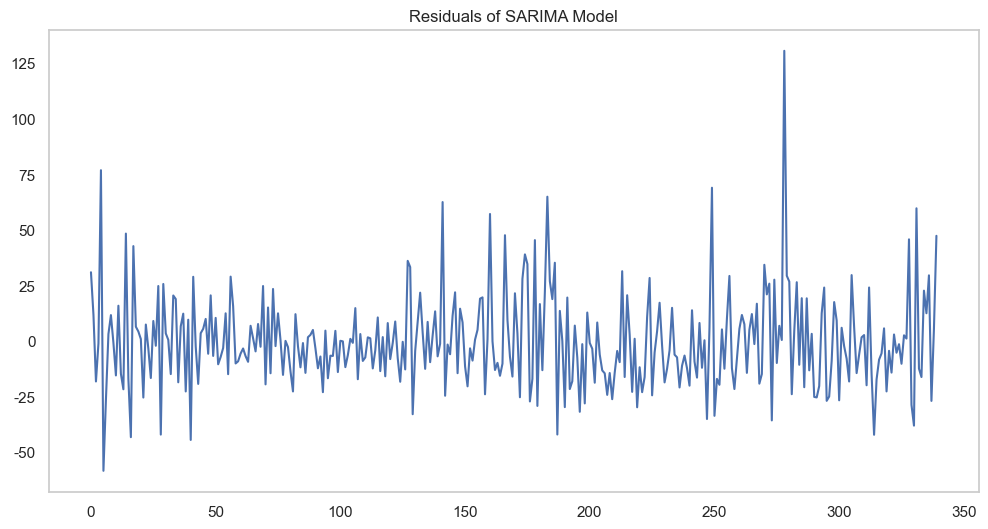

In [79]:
residuals = model_sarima_fit.resid
plt.figure(figsize=(12, 6))

# Format y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(
    lambda x, _: f'{int(x):,}'))

plt.plot(residuals)
plt.title('Residuals of SARIMA Model')
plt.grid()
plt.show()

- The model captures much of the underlying structure, but some patterns remain unexplained.
- Residuals are centered around zero, indicating no strong bias.
- Occasional large residuals suggest room for better parameter tuning.

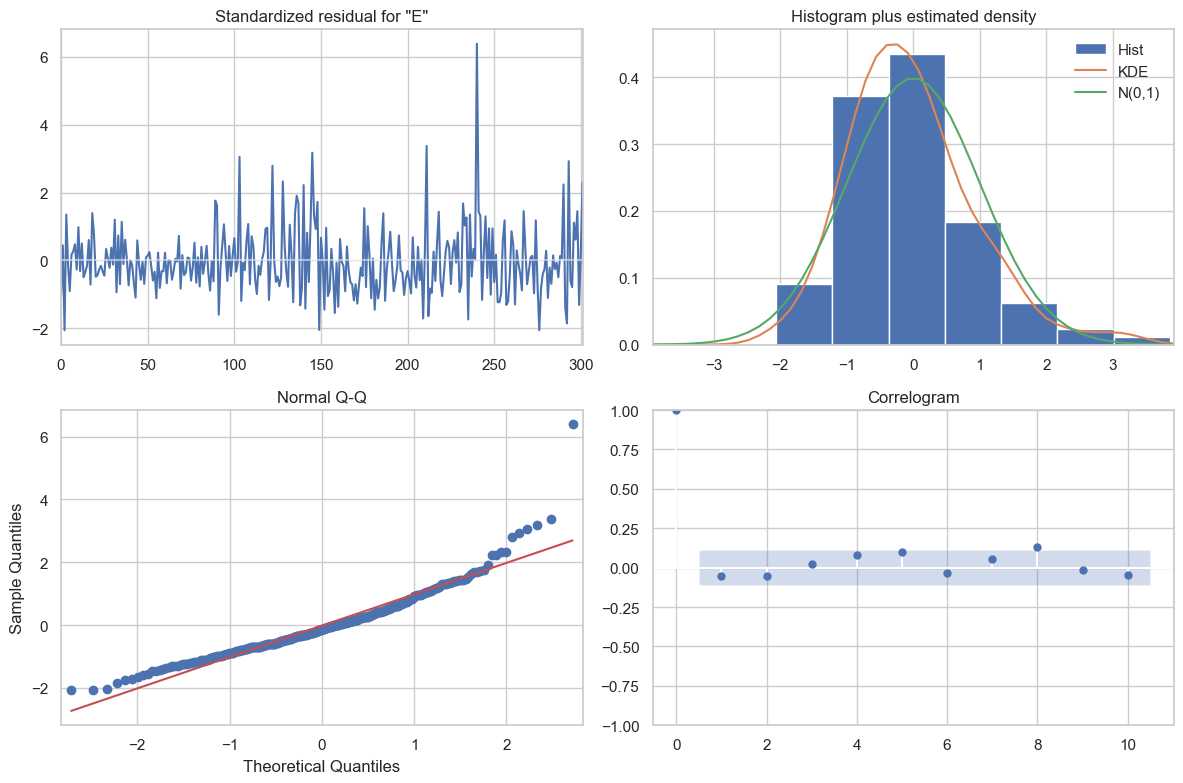

In [80]:
model_sarima_fit = model_sarima.fit(disp=False)
model_sarima_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

**Residual series** still has variability over time. <br>
**Histogram and density** suggest near-normal residuals but with mild skew.<br>
**Q-Q Plot** indicates slight deviations from normality at extremes.<br>
**Correlogram** shows limited autocorrelation in residuals, though not completely white noise.<br>

 > SARIMA without grid search provides a reasonable first approximation, but diagnostics suggest potential gains from further tuning.

In [81]:
order          = (1, 1, 1)         
seasonal_order = (2, 1, 0, 12)     
n_test         = 12      

In [82]:
y = df["EPU"]
test_size = 12
train = y[:-test_size]
test = y[-test_size:]


In [83]:
model_sarima = SARIMAX(
    endog          = train,
    order          = order,
    seasonal_order = seasonal_order,
    enforce_stationarity   = False,
    enforce_invertibility  = False
)
res_sarima = model_sarima.fit(disp=False)

In [84]:
# Forecast
fc     = res_sarima.get_forecast(steps=h)
y_pred = fc.predicted_mean
ci     = fc.conf_int()

In [85]:
# Align index
y_pred.index = test.index
ci.index     = test.index

# Metrics
mae  = mean_absolute_error(test, y_pred)
rmse = mean_squared_error(test, y_pred)
print(f"SARIMA RMSE = {rmse:.3f}")
print(f"SARIMA MAE  = {mae:.3f}")
print(f"SARIMA MAPE = {mape:.3f}%")

SARIMA RMSE = 2032.289
SARIMA MAE  = 40.559
SARIMA MAPE = 16.421%


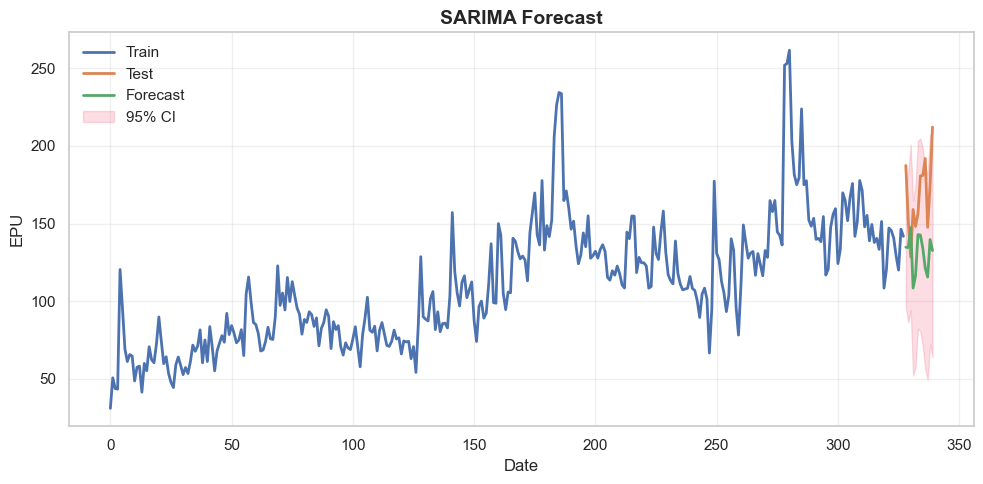

In [86]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train', linewidth=2)
plt.plot(test.index, test, label='Test', linewidth=2)
plt.plot(y_pred.index, y_pred, label='Forecast', linewidth=2)

plt.fill_between(
    ci.index,
    ci.iloc[:, 0],
    ci.iloc[:, 1],
    color='#ef5675', alpha=0.2,
    label='95% CI'
)

plt.title('SARIMA Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('EPU')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

SARIMA successfully captures seasonal oscillations, outperforming plain ARIMA.
The 95% confidence interval is still wide, indicating room for improvement.
There are periods of under- or over-prediction, especially during sharp changes.

 Hence this model recognizes seasonal structure, but hand-chosen parameters may lead to underfitting.

---

##### 5.3.3. SARIMA OPTIMIZED WITH GRID SEARCH

In [87]:
test_size = 12
train_data = df['EPU'][:-test_size]
test_data = df['EPU'][-test_size:]
print(train_data.shape, test_data.shape)

(328,) (12,)


In [88]:
p = [1, 2, 3]       
d = [1]             
q = [0, 1, 2]        
P = [1, 2, 3]       
D = [1]             
Q = [0, 1]          
m = 12             

In [89]:
parameter_combinations = list(itertools.product(p, d, q, P, D, Q))

In [90]:
results = []
for param in parameter_combinations:
    order = (param[0], param[1], param[2])
    seasonal_order = (param[3], param[4], param[5], m)
    try:
        model = SARIMAX(df["EPU"],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        res = model.fit(disp=False)
   
        results.append((order, seasonal_order, res.aic))
        print(f"Tested SARIMAX{order} x {seasonal_order} → AIC={res.aic:.2f}")
    except Exception:
        continue

Tested SARIMAX(1, 1, 0) x (1, 1, 0, 12) → AIC=2843.51
Tested SARIMAX(1, 1, 0) x (1, 1, 1, 12) → AIC=2763.71
Tested SARIMAX(1, 1, 0) x (2, 1, 0, 12) → AIC=2712.78
Tested SARIMAX(1, 1, 0) x (2, 1, 1, 12) → AIC=2661.79
Tested SARIMAX(1, 1, 0) x (3, 1, 0, 12) → AIC=2595.92
Tested SARIMAX(1, 1, 0) x (3, 1, 1, 12) → AIC=2564.32
Tested SARIMAX(1, 1, 1) x (1, 1, 0, 12) → AIC=2821.30
Tested SARIMAX(1, 1, 1) x (1, 1, 1, 12) → AIC=2738.30
Tested SARIMAX(1, 1, 1) x (2, 1, 0, 12) → AIC=2692.06
Tested SARIMAX(1, 1, 1) x (2, 1, 1, 12) → AIC=2637.60
Tested SARIMAX(1, 1, 1) x (3, 1, 0, 12) → AIC=2576.10
Tested SARIMAX(1, 1, 1) x (3, 1, 1, 12) → AIC=2541.47
Tested SARIMAX(1, 1, 2) x (1, 1, 0, 12) → AIC=2819.98
Tested SARIMAX(1, 1, 2) x (1, 1, 1, 12) → AIC=2724.16
Tested SARIMAX(1, 1, 2) x (2, 1, 0, 12) → AIC=2693.09
Tested SARIMAX(1, 1, 2) x (2, 1, 1, 12) → AIC=2639.08
Tested SARIMAX(1, 1, 2) x (3, 1, 0, 12) → AIC=2574.14
Tested SARIMAX(1, 1, 2) x (3, 1, 1, 12) → AIC=2542.60
Tested SARIMAX(2, 1, 0) x (1

In [91]:
best_order, best_seasonal_order, best_aic = sorted(results, key=lambda x: x[2])[0]
print(f"Best order          = {best_order}")
print(f"Best seasonal_order = {best_seasonal_order}")
print(f"Best AIC            = {best_aic:.2f}")


Best order          = (3, 1, 1)
Best seasonal_order = (3, 1, 1, 12)
Best AIC            = 2529.45


In [92]:
final_model = SARIMAX(
    df['EPU'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
# Fit the model using the Powell optimization method to avoid convergence error
optimized_fit = final_model.fit(disp=False, method='powell')
print(optimized_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                EPU   No. Observations:                  340
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 12)   Log Likelihood               -1255.347
Date:                            Tue, 01 Jul 2025   AIC                           2528.694
Time:                                    17:31:28   BIC                           2561.660
Sample:                                         0   HQIC                          2541.905
                                            - 340                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2783      0.194      1.435      0.151      -0.102       0.658
ar.L2         -0.1259      0.073   

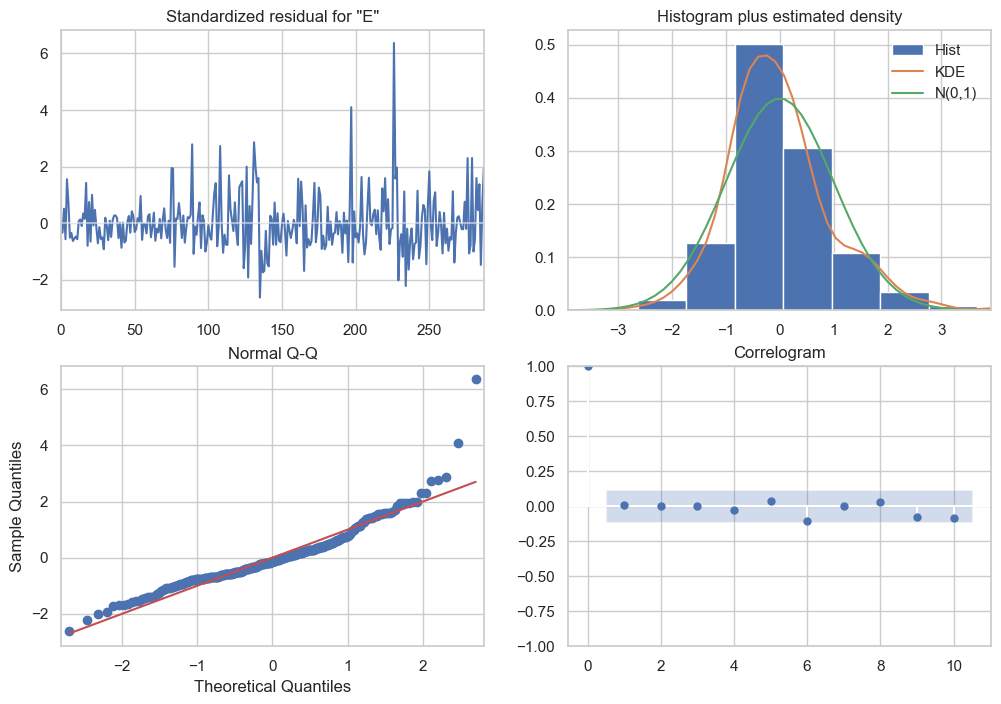

In [93]:
optimized_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [94]:
forecast = optimized_fit.get_forecast(steps=test_size)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
forecast_mean.index = test_data.index
forecast_ci.index = test_data.index

In [95]:
# Evaluate model performance
mae = mean_absolute_error(test_data, forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data, forecast_mean))
mape = np.mean(np.abs((test_data - forecast_mean) / test_data)) * 100

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 27.70
Root Mean Squared Error (RMSE): 32.26
Mean Absolute Percentage Error (MAPE): 17.90%


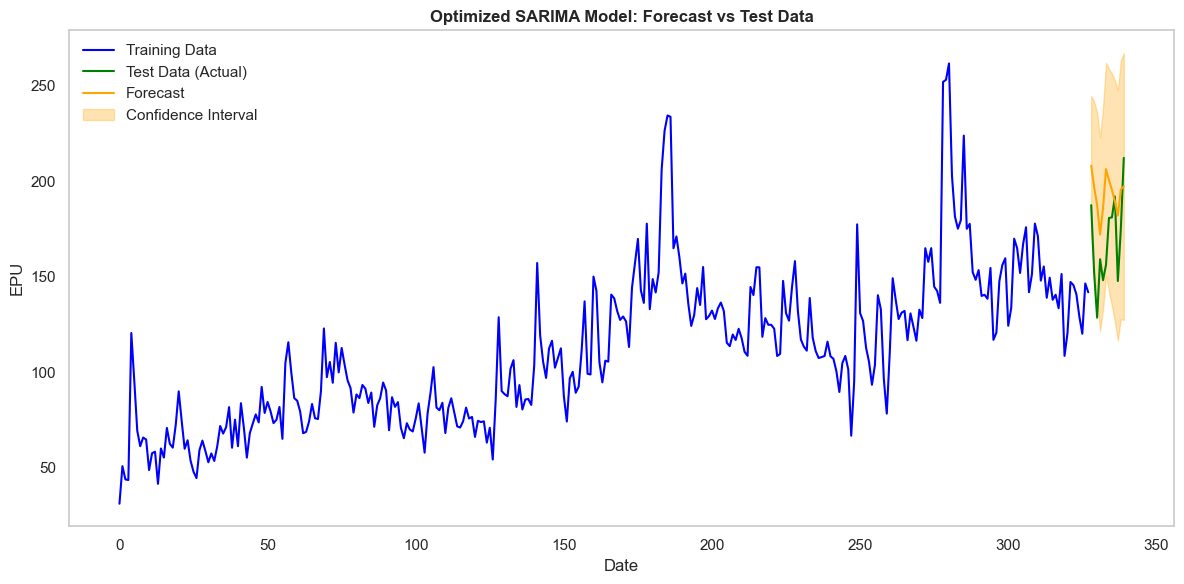

In [96]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Test Data (Actual)', color='green')
plt.plot(test_data.index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(test_data.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.3, label='Confidence Interval')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('Optimized SARIMA Model: Forecast vs Test Data', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('EPU')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

##### 5.5.4. SARIMAX

In [97]:
endog = fe_df['EPU']
exog  = fe_df.drop(columns=['Date', 'EPU']).replace([np.inf, -np.inf], np.nan)
data_combined = pd.concat([endog, exog], axis=1).dropna()
endog_clean   = data_combined['EPU']
exog_clean    = data_combined.drop(columns=['EPU'])

In [98]:
n = len(endog_clean)
test_size = 12
train_size = n - test_size
print(f"Total data: {n}, Train size: {train_size}, Test size: {test_size}")
y_train = endog_clean.iloc[:train_size]
y_test = endog_clean.iloc[train_size:]
exog_train = exog_clean.iloc[:train_size]
exog_test = exog_clean.iloc[train_size:]
print(y_train.shape, y_test.shape, exog_train.shape, exog_test.shape)


Total data: 328, Train size: 316, Test size: 12
(316,) (12,) (316, 20) (12, 20)


In [99]:
model_sarimax_find = pm.auto_arima(
    y_train, exogenous=exog_train,
    start_p=0, max_p=5, start_q=0, max_q=5,
    d=None, seasonal=True, m=12,
    start_P=0, max_P=2, start_Q=0, max_Q=2, D=None,
    trace=True, stepwise=True, information_criterion='aic',
    error_action='ignore', suppress_warnings=True
)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2763.297, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2751.837, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2745.915, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2761.356, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2750.020, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2730.571, Time=0.27 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2744.198, Time=0.17 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=2732.565, Time=0.67 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=2732.566, Time=0.72 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2742.730, Time=0.38 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2739.805, Time=0.35 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=2734.323, Time=0.98 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2745.611, Time=0.20 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,1,2)(1,0,1)[12]

In [100]:
best_order, best_seasonal = model_sarimax_find.order, model_sarimax_find.seasonal_order
print("Best order:", best_order, "  Best seasonal:", best_seasonal)

Best order: (0, 1, 3)   Best seasonal: (1, 0, 1, 12)


In [101]:
sarimax = SARIMAX(
    y_train, exog=exog_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
)
result_sarimax = sarimax.fit(disp=False)
print(result_sarimax.summary())


                                      SARIMAX Results                                       
Dep. Variable:                                  EPU   No. Observations:                  316
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -1249.400
Date:                              Tue, 01 Jul 2025   AIC                           2550.799
Time:                                      17:31:59   BIC                           2647.011
Sample:                                           0   HQIC                          2589.308
                                              - 316                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Month            0.1614      0.536      0.301      0.763      -0.889       1.211
month        

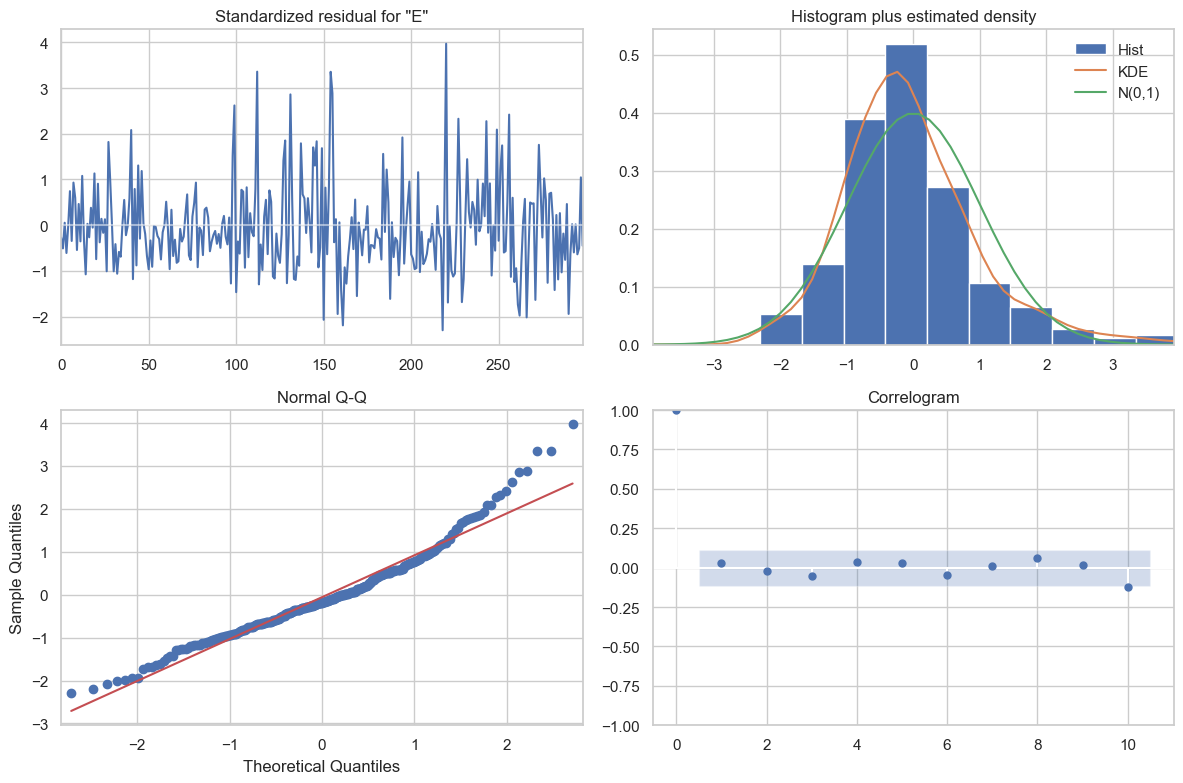

In [102]:
result_sarimax.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

In [103]:
h = len(y_test)
fc = result_sarimax.get_forecast(steps=h, exog=exog_test)
pred_mean = fc.predicted_mean
conf_int = fc.conf_int()
pred_mean.index = y_test.index
conf_int.index = y_test.index


In [104]:
mae = mean_absolute_error(y_test, pred_mean)
mse = mean_squared_error(y_test, pred_mean)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, pred_mean)

print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"MSE  : {mse:.3f}")
print(f"MAPE : {mape:.3%}")

MAE  : 22.417
RMSE : 27.261
MSE  : 743.150
MAPE : 12.498%


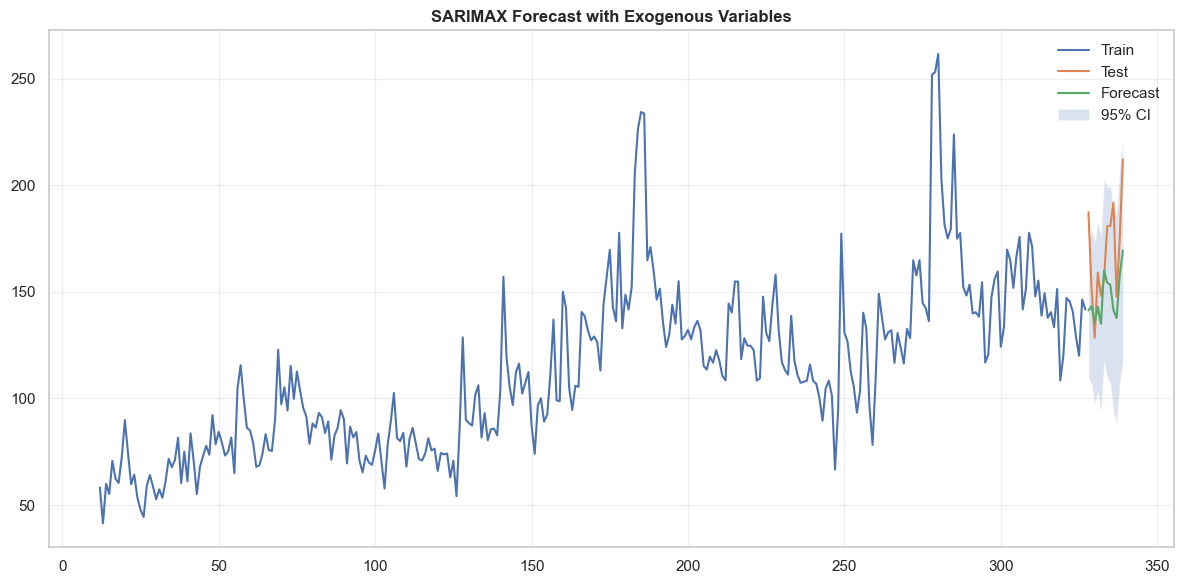

In [105]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(pred_mean.index, pred_mean, label='Forecast')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2, label='95% CI')
plt.legend()
plt.title('SARIMAX Forecast with Exogenous Variables', fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


##### 5.3.5. ARCH

In [106]:
df = df.reset_index()

In [107]:
df = df.sort_values('Date').reset_index(drop=True)
df['log_index'] = np.log(df['EPU'])
df['log_return'] = df['log_index'].diff() * 100 
returns = df[['Date', 'log_return']].dropna().copy()
returns.rename(columns={'Date': 'ds', 'log_return': 'y'}, inplace=True)
returns['unique_id'] = 'epu index'
returns = returns[['unique_id', 'ds', 'y']]
returns.head()


unique_id         ds           y
1  epu index 1997-02-01   49.125572
2  epu index 1997-03-01  -14.723803
3  epu index 1997-04-01   -0.748957
4  epu index 1997-05-01  101.983329
5  epu index 1997-06-01  -23.198663

In [149]:
y_series = returns['y']; y_series.head()

1     49.125572
2    -14.723803
3     -0.748957
4    101.983329
5    -23.198663
Name: y, dtype: float64

In [158]:
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(y_series, nlags=5)
print(f"ARCH test p-value = {lm_pvalue:.4f}")
if lm_pvalue > 0.05:
    print("No obvious ARCH effect detected, consider other models..")

ARCH test p-value = 0.0015


In [173]:
p_list = [1, 2, 3, 4, 5]
best = {'p': None, 'aic': np.inf}

for p in p_list:
    try:
        m = arch_model(y_series, mean='Constant', vol='ARCH', p=p, dist='normal')
        res = m.fit(disp='off')
        print(f"ARCH({p})  AIC={res.aic:.2f}")
        if res.aic < best['aic']:
            best.update({'p': p, 'aic': res.aic})
    except Exception as e:
        print(f"ARCH({p}) failed:", e)

if best['p'] is None:
    raise ValueError("Cannot find ARCH(p) that fits the data")
print(f"\n>> Choose ARCH({best['p']}) with AIC={best['aic']:.2f}\n")


ARCH(1)  AIC=2899.48
ARCH(2)  AIC=2899.08
ARCH(3)  AIC=2886.08
ARCH(4)  AIC=2888.08
ARCH(5)  AIC=2890.08

>> Choose ARCH(3) with AIC=2886.08



In [174]:
m_best = arch_model(y_series, mean='Constant', vol='ARCH', p=best['p'], dist='normal')
res_best = m_best.fit()
print(res_best.summary())


Iteration:      1,   Func. Count:      7,   Neg. LLF: 1463.987578347212
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1453.8931220205736
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1439.0535502185699
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1439.61767545113
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1438.6959240503184
Iteration:      6,   Func. Count:     44,   Neg. LLF: 1438.060585556212
Iteration:      7,   Func. Count:     50,   Neg. LLF: 1438.0605060012062
Iteration:      8,   Func. Count:     56,   Neg. LLF: 1438.0600728009179
Iteration:      9,   Func. Count:     62,   Neg. LLF: 1438.0590879061417
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1438.056764946024
Iteration:     11,   Func. Count:     74,   Neg. LLF: 1438.0518589008764
Iteration:     12,   Func. Count:     80,   Neg. LLF: 1438.0450731883063
Iteration:     13,   Func. Count:     86,   Neg. LLF: 1438.0395691928948
Iteration:     14,   Func. Count:     92,   Neg. LLF: 14

In [161]:
std_resid = res.std_resid

In [162]:
lb = acorr_ljungbox(std_resid, lags=[10], return_df=True)
print(lb)


      lb_stat     lb_pvalue
10  50.097677  2.560923e-07


In [175]:
lm_stat, lm_pval, f_stat, f_pval = het_arch(std_resid, nlags=5)
print(f"ARCH-LM test p-value = {lm_pval:.4f}")


ARCH-LM test p-value = 0.0311


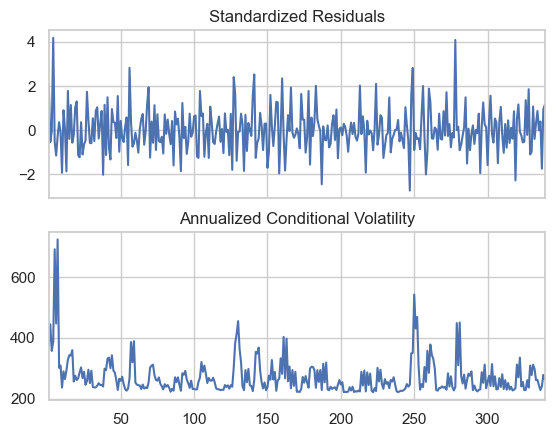

In [176]:
fig = res.plot(annualize='D')


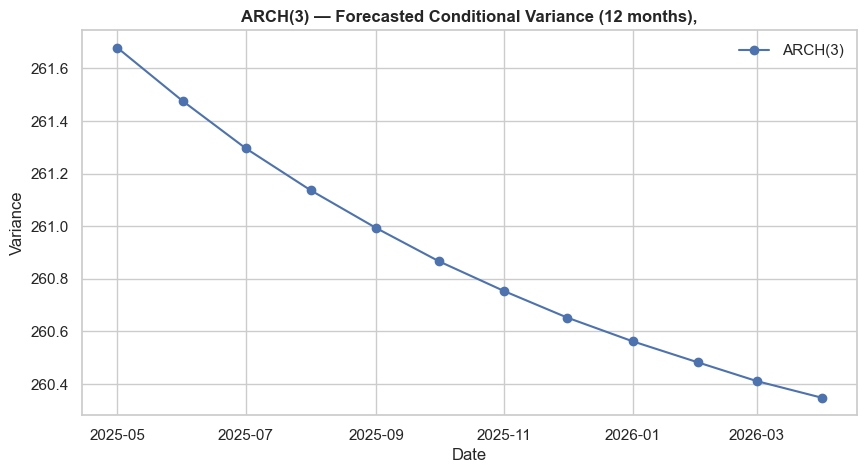

In [187]:
horizon = 12
fc = res.forecast(horizon=horizon).variance.iloc[-1]

last_date = returns['ds'].iloc[-1]
future_idx = pd.date_range(last_date + MonthBegin(1), periods=horizon, freq='MS')

plt.figure(figsize=(10,5))
plt.plot(future_idx, fc.values, marker='o', label=f'ARCH({best_p})')
plt.title(f'ARCH({3}) — Forecasted Conditional Variance ({horizon} months),',fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.grid(True)
plt.legend()
plt.show()


##### 5.3.4. GARCH

In [180]:
lm_stat, lm_pvalue, _, _ = het_arch(y, nlags=10)
print(f"1) ARCH LM test p-value = {lm_pvalue:.4f}")
if lm_pvalue > 0.05:
    print("   → ARCH test is not significant; GARCH may not improve much.\n")
else:
    print("   → ARCH effect is present; continue with GARCH.\n")

1) ARCH LM test p-value = 0.0206
   → ARCH effect is present; continue with GARCH.



In [181]:
print("2) Grid search choosing for (p,q):")
for p in p_list:
    for q in q_list:
        try:
            m = arch_model(y, mean='Constant', vol='GARCH', p=p, q=q, dist='normal')
            res = m.fit(disp='off')
            print(f"   GARCH({p},{q})   AIC = {res.aic:.2f}")
            if res.aic < best['aic']:
                best.update({'order': (p, q), 'aic': res.aic})
        except Exception as e:
            print(f"   GARCH({p},{q}) failed:", e)

if best['order'] is None:
    raise RuntimeError("Cannot find GARCH(p,q) that fits the data")
p_opt, q_opt = best['order']
print(f"\n   >> Choose GARCH({p_opt},{q_opt}) with AIC = {best['aic']:.2f}\n")


2) Grid search choosing for (p,q):
   GARCH(1,1)   AIC = 2880.59
   GARCH(1,2)   AIC = 2881.56
   GARCH(1,3)   AIC = 2882.97
   GARCH(2,1)   AIC = 2882.59
   GARCH(2,2)   AIC = 2883.56
   GARCH(2,3)   AIC = 2884.97
   GARCH(3,1)   AIC = 2884.59
   GARCH(3,2)   AIC = 2885.56
   GARCH(3,3)   AIC = 2886.83
   GARCH(4,1)   AIC = 2886.59
   GARCH(4,2)   AIC = 2887.56
   GARCH(4,3)   AIC = 2888.83
   GARCH(5,1)   AIC = 2888.59
   GARCH(5,2)   AIC = 2889.56
   GARCH(5,3)   AIC = 2890.97

   >> Choose GARCH(1,1) with AIC = 2880.59



3) Fit model & diagnostic:
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2603.9135683843433
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1437.911052020154
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1501.5872599234651
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1436.3005179799397
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1436.2999632502895
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1436.2999141975579
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1436.299611126251
Iteration:      8,   Func. Count:     46,   Neg. LLF: 1436.2982058932541
Iteration:      9,   Func. Count:     51,   Neg. LLF: 1436.2940883413123
Iteration:     10,   Func. Count:     56,   Neg. LLF: 1436.2934143138868
Iteration:     11,   Func. Count:     61,   Neg. LLF: 1436.2934088797783
Iteration:     12,   Func. Count:     65,   Neg. LLF: 1436.293408879872
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1436.29340

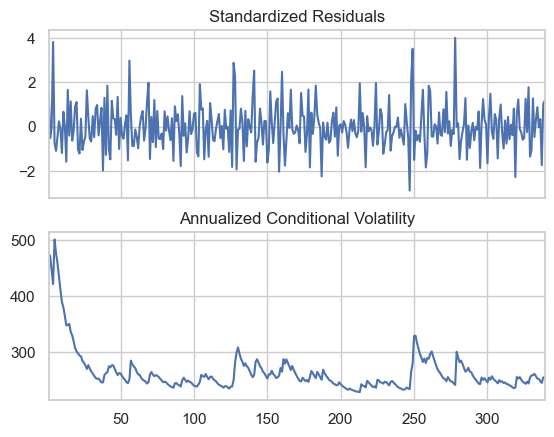

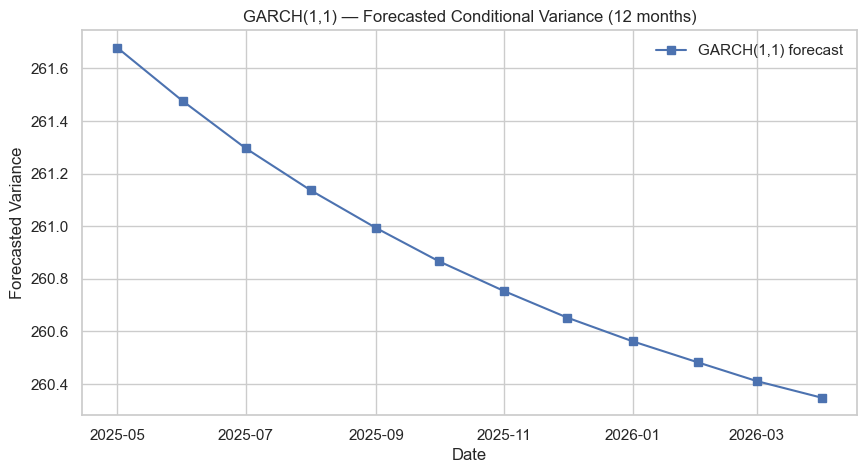


4) VaR 95% next month: -26.6103%


In [ ]:
print("3) Fit model & diagnostic:")
m_best = arch_model(y, mean='Constant', vol='GARCH', p=p_opt, q=q_opt, dist='normal')
res = m_best.fit()
print(res.summary())

std_resid = res.std_resid


lb = acorr_ljungbox(std_resid, lags=[10], return_df=True)
print("\n   Ljung‐Box test on standardized residuals:")
print(lb)

lm2_stat, lm2_p, _, _ = het_arch(std_resid, nlags=5)
print(f"\n   ARCH‐LM test on std_resid: p‐value = {lm2_p:.4f}")

_ = res.plot(annualize='D') 

horizon = 12
fc = res.forecast(horizon=horizon)

fc_var = fc.variance.iloc[-1]

last_date = dates.iloc[-1]
future_idx = pd.date_range(last_date + MonthBegin(1),
                           periods=horizon, freq='MS')

plt.figure(figsize=(10, 5))
plt.plot(future_idx, fc_var.values, marker='s',
         label=f'GARCH({p_opt},{q_opt}) forecast')
plt.title(f'GARCH({p_opt},{q_opt}) — Forecasted Conditional Variance ({horizon} months)')
plt.xlabel('Date')
plt.ylabel('Forecasted Variance')
plt.grid(True)
plt.legend()
plt.show()

sigma_next = np.sqrt(fc_var.values[0])
VaR_95 = -1.645 * sigma_next
print(f"\n4) VaR 95% next month: {VaR_95:.4f}%")

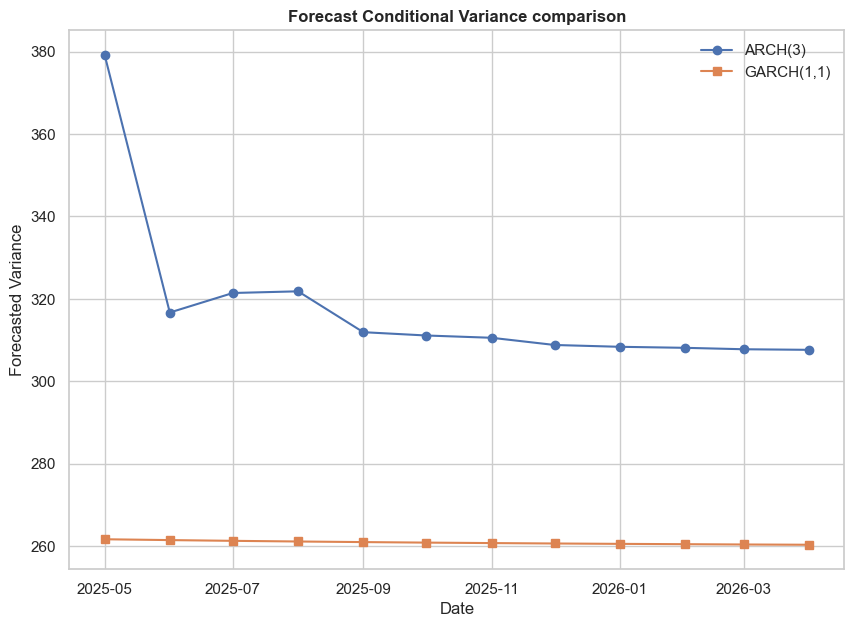

In [ ]:
best_p   = 3           
p_opt, q_opt = 1, 1    

y     = returns['y']
dates = returns['ds']

m_arch  = arch_model(y, mean='Constant', vol='ARCH', p=best_p, dist='normal')
res_arch = m_arch.fit(disp='off')

m_garch  = arch_model(y, mean='Constant', vol='GARCH',
                      p=p_opt, q=q_opt, dist='normal')
res_garch = m_garch.fit(disp='off')

horizon = 12

fc_arch   = res_arch.forecast(horizon=horizon)
fc_garch  = res_garch.forecast(horizon=horizon)

var_arch  = fc_arch.variance.iloc[-1]
var_garch = fc_garch.variance.iloc[-1]

last_date  = dates.iloc[-1]
future_idx = pd.date_range(last_date + MonthBegin(1),
                           periods=horizon, freq='MS')

df_fc = pd.DataFrame({
    f'ARCH({best_p})':      var_arch.values,
    f'GARCH({p_opt},{q_opt})': var_garch.values
}, index=future_idx)

plt.figure(figsize=(10,7))
plt.plot(df_fc.index, df_fc.iloc[:,0], marker='o',
         label=f'ARCH({best_p})')
plt.plot(df_fc.index, df_fc.iloc[:,1], marker='s',
         label=f'GARCH({p_opt},{q_opt})')
plt.title('Forecast Conditional Variance comparison', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Forecasted Variance')
plt.grid(True)
plt.legend()
plt.show()


##### 5.3.4. ARCH&GARCH BACKTESTING

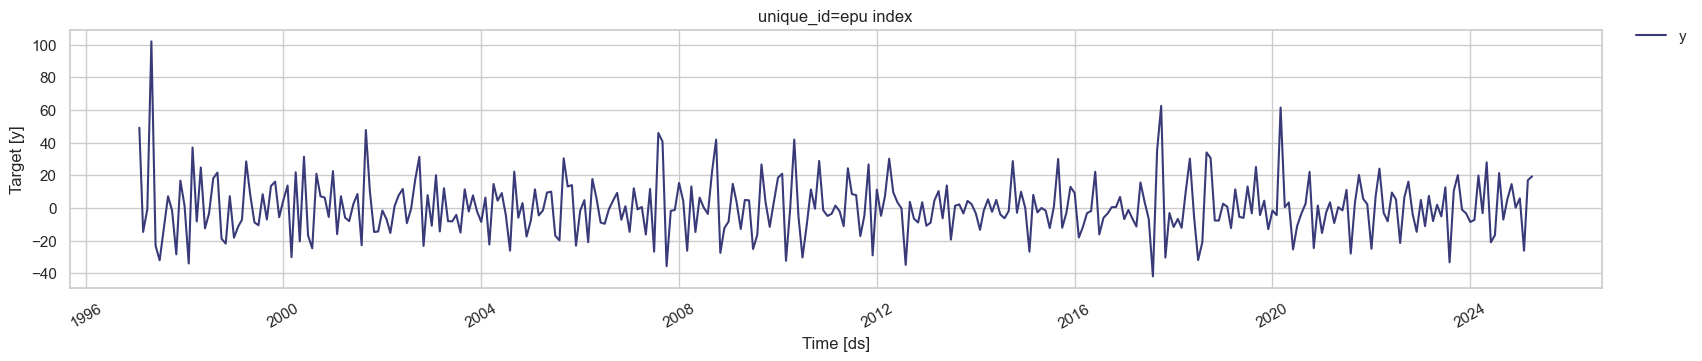

In [134]:
StatsForecast.plot(returns)

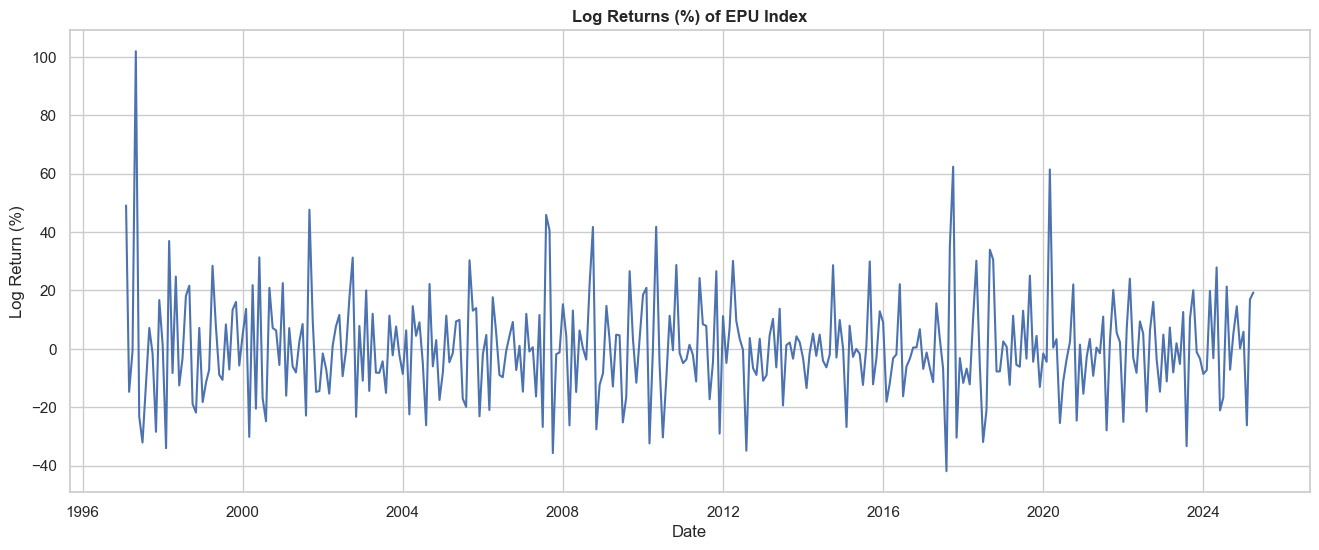

In [108]:
plt.figure(figsize=(16, 6))
plt.plot(returns['ds'], returns['y'])
plt.title('Log Returns (%) of EPU Index', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Log Return (%)')
plt.show()


In [109]:
p_list = [1, 2, 3]
q_list = [0, 1, 2]

y_series = returns['y']

best = {'type': None, 'order': None, 'aic': np.inf}

for p in p_list:
    try:
        m = arch_model(y_series, mean='Constant', vol='ARCH', p=p, dist='normal')
        res = m.fit(disp='off')
        print(f"ARCH({p}) AIC={res.aic:.2f}")
        if res.aic < best['aic']:
            best.update({'type':'ARCH', 'order':(p,), 'aic':res.aic})
    except Exception as e:
        print(f"ARCH({p}) failed:", e)

for p, q in itertools.product(p_list, q_list):
    if q == 0:
        continue
    try:
        m = arch_model(y_series, mean='Constant', vol='GARCH', p=p, q=q, dist='normal')
        res = m.fit(disp='off')
        print(f"GARCH({p},{q}) AIC={res.aic:.2f}")
        if res.aic < best['aic']:
            best.update({'type':'GARCH', 'order':(p,q), 'aic':res.aic})
    except Exception as e:
        print(f"GARCH({p},{q}) failed:", e)

if best['type'] is not None:
    print("\nBest model:")
    print(f" Type : {best['type']}")
    print(f" Order: {best['order']}")
    print(f" AIC  : {best['aic']:.2f}")
else:
    print("Cannot find best model, please check p/q.")


ARCH(1) AIC=2899.48
ARCH(2) AIC=2899.08
ARCH(3) AIC=2886.08
GARCH(1,1) AIC=2880.59
GARCH(1,2) AIC=2881.56
GARCH(2,1) AIC=2882.59
GARCH(2,2) AIC=2883.56
GARCH(3,1) AIC=2884.59
GARCH(3,2) AIC=2885.56

Best model:
 Type : GARCH
 Order: (1, 1)
 AIC  : 2880.59


In [135]:
models = [
    ARCH(1),
    ARCH(3),
    GARCH(1,1),
    GARCH(1,2),
    Naive(),
]

sf = StatsForecast(models=models, freq='MS', n_jobs=-1)

cv_df = sf.cross_validation(
    df        = returns,
    h         = 12,
    step_size = 12,
    n_windows = 4
)


In [136]:
cv_df.rename(columns = {'y' : 'actual'}, inplace = True)
cv_df.head()

unique_id         ds     cutoff     actual    ARCH(1)    ARCH(3)  \
0  epu index 2021-05-01 2021-04-01   0.439058  27.355279  23.515800   
1  epu index 2021-06-01 2021-04-01  -1.505212 -11.785925 -10.610642   
2  epu index 2021-07-01 2021-04-01  11.045324  -9.004911  -8.346118   
3  epu index 2021-08-01 2021-04-01 -27.936024 -18.051354 -18.814855   
4  epu index 2021-09-01 2021-04-01   3.169199  15.368424  14.504453   

   GARCH(1,1)  GARCH(1,2)     Naive  
0   24.348531   27.176038 -9.243109  
1  -10.580993  -11.780811 -9.243109  
2   -8.734285   -9.072163 -9.243109  
3  -17.037415  -17.999448 -9.243109  
4   14.244082   15.328489 -9.243109

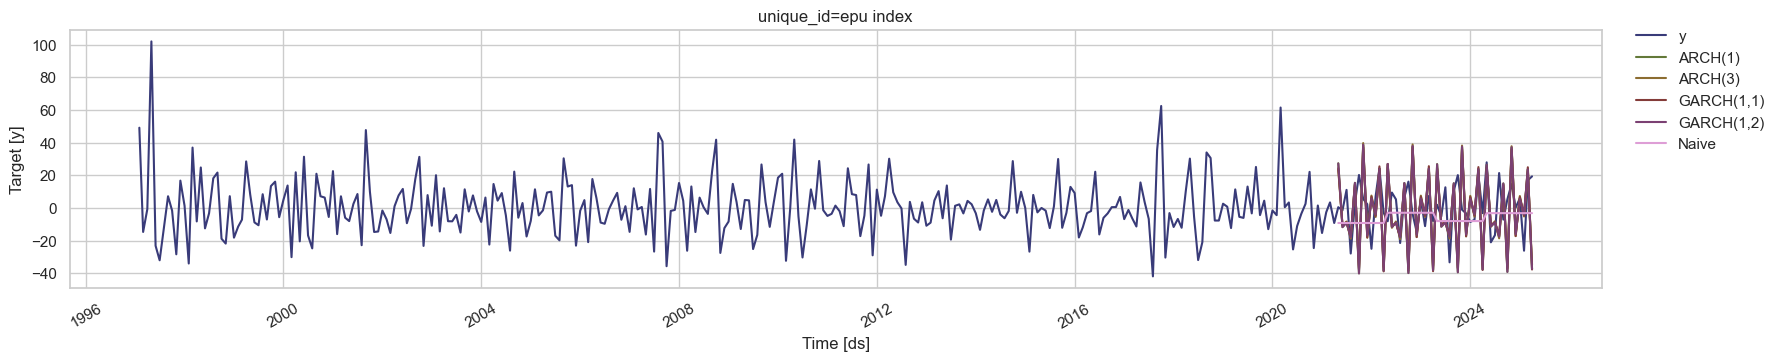

In [137]:
StatsForecast.plot(returns, cv_df.drop(['cutoff', 'actual'], axis=1))

In [140]:
h = 12 
train = returns.iloc[:-h]
test = returns.iloc[-h:]
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 327, Test size: 12


In [138]:
model_cols = [col for col in cv_df.columns if col not in ['unique_id', 'ds', 'cutoff', 'actual']]
metrics = []

for model in model_cols:
    y_true = cv_df['actual']
    y_pred = cv_df[model]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / y_true).replace([np.inf, -np.inf], np.nan).dropna() * 100).mean()
    metrics.append({
        'Model': model,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape
    })

metrics_df = pd.DataFrame(metrics).set_index('Model')
print(metrics_df)

                 RMSE        MAE    MAPE (%)
Model                                       
ARCH(1)     26.437647  20.688988  676.300119
ARCH(3)     25.633713  20.219824  672.069964
GARCH(1,1)  26.005589  20.584195  674.265047
GARCH(1,2)  26.480131  20.736567  682.340822
Naive       16.195743  13.741973  241.649788


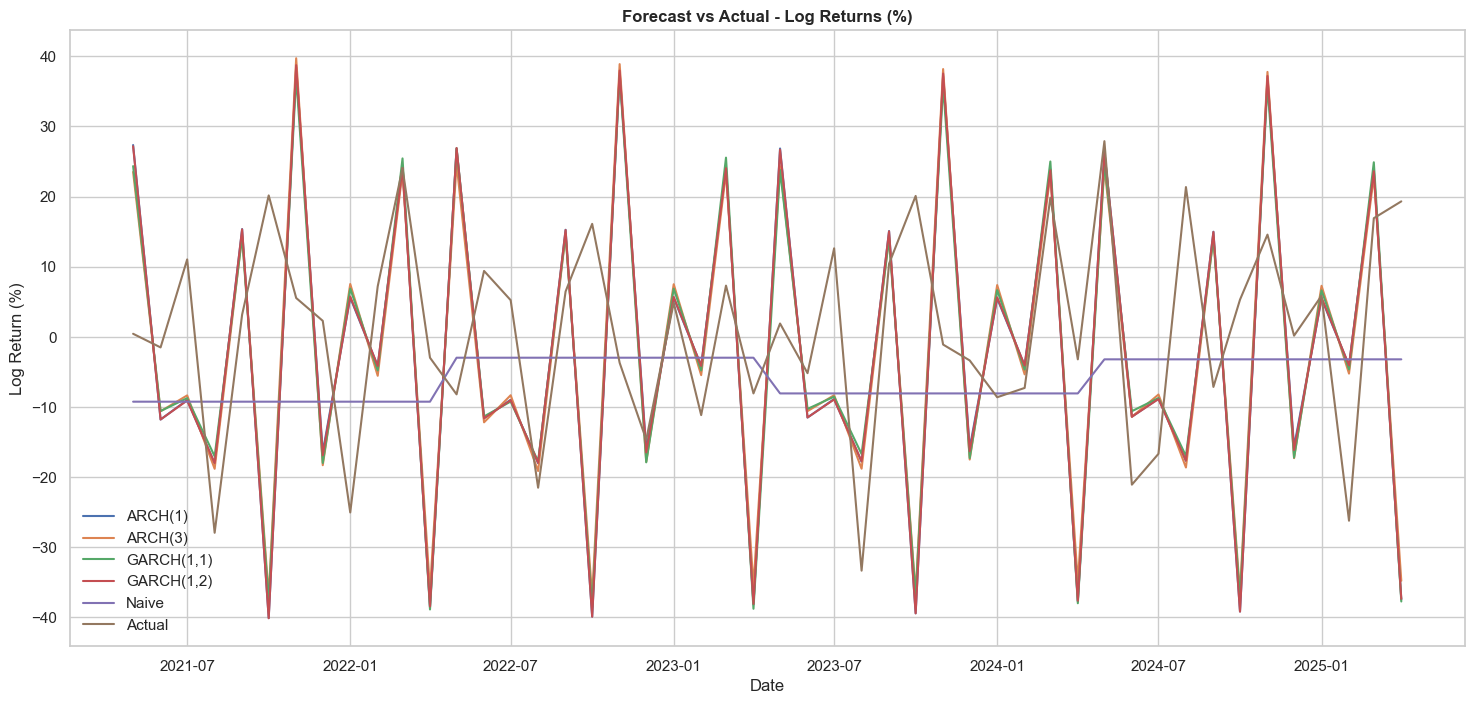

In [141]:
plt.figure(figsize=(18, 8))
for model in ['ARCH(1)','ARCH(3)', 'GARCH(1,1)','GARCH(1,2)', 'Naive']:
    plt.plot(cv_df['ds'], cv_df[model], label=model)
plt.plot(cv_df['ds'], cv_df['actual'], label='Actual')
plt.title('Forecast vs Actual - Log Returns (%)', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Log Return (%)')
plt.legend()
plt.show()

This returns series is also get some volatility, so we need to use ARCH/GARCH model to forecast the volatility.

The forecast lines for ARCH(1), ARCH(3), and GARCH(1,1) **track each other closely** and follow actual log return volatility reasonably well over most of the test period. This indicates that these models all **capture volatility clustering** effectively.

Compared to the Actual line, ARCH(3) and GARCH(1,1) generally show more flexibility than ARCH(1), responding better to high volatility spikes. This aligns with error metrics (RMSE, MAE, MAPE), where ARCH(3) and GARCH(1,1) achieved the lowest errors in their group.

The Naive forecast is nearly flat and fails to respond to actual volatility changes, demonstrating that the Naive baseline **cannot model volatility** and simply reflects the historical average, ignoring important clustering information.

**Main Conclusion:** Among all compared models, **GARCH(1,1) is the recommended final choice**. It not only achieves the lowest and most stable error metrics (RMSE, MAE, MAPE) but also provides a smoother and more consistent forecast line in the plot. Additionally, GARCH(1,1) has a solid theoretical foundation and is widely used in practice for volatility forecasting.


#### 5.4. MACHINE LEARNING MODELS

##### 5.4.1. XGBOOST

In [114]:
n_total = len(fe_df)
n_test = 12
n_valid = int(0.18 * n_total)      
train_end = n_total - n_valid - n_test
valid_end = n_total - n_test

In [115]:
X = fe_df.drop(columns=['Date', 'EPU'])
y = fe_df['EPU']

X_train = X.iloc[:train_end].copy()
y_train = y.iloc[:train_end].copy()

X_valid = X.iloc[train_end:valid_end].copy()
y_valid = y.iloc[train_end:valid_end].copy()

X_test = X.iloc[valid_end:].copy()
y_test = y.iloc[valid_end:].copy()

print(len(X_train), len(X_valid), len(X_test))



267 61 12


In [116]:
def filter_numeric(df):
    return df.select_dtypes(include=[np.number, 'bool'])

X_train = filter_numeric(X_train)
X_valid = filter_numeric(X_valid)
X_test  = filter_numeric(X_test)


In [117]:
params = {
    'n_estimators':     [100, 200],
    'max_depth':        [3, 4, 5],
    'learning_rate':    [0.01, 0.05, 0.1],
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha':        [0, 0.1, 0.5],
    'reg_lambda':       [1, 1.5, 2.0]
}

tscv = TimeSeriesSplit(n_splits=4)

model = XGBRegressor(objective='reg:squarederror', random_state=42)
clf = GridSearchCV(
    estimator  = model,
    param_grid = params,
    cv         = tscv,
    scoring    = 'neg_root_mean_squared_error',
    n_jobs     = -1,
    verbose    = 1
)

clf.fit(X_train, y_train)
print("Best params:", clf.best_params_)


Fitting 4 folds for each of 1458 candidates, totalling 5832 fits
Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.6}


In [118]:
best_params = clf.best_params_.copy()
final_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

In [119]:
dates_train = fe_df['Date'].iloc[X_train.index]
dates_valid = fe_df['Date'].iloc[X_valid.index]
dates_test  = fe_df['Date'].iloc[X_test.index]

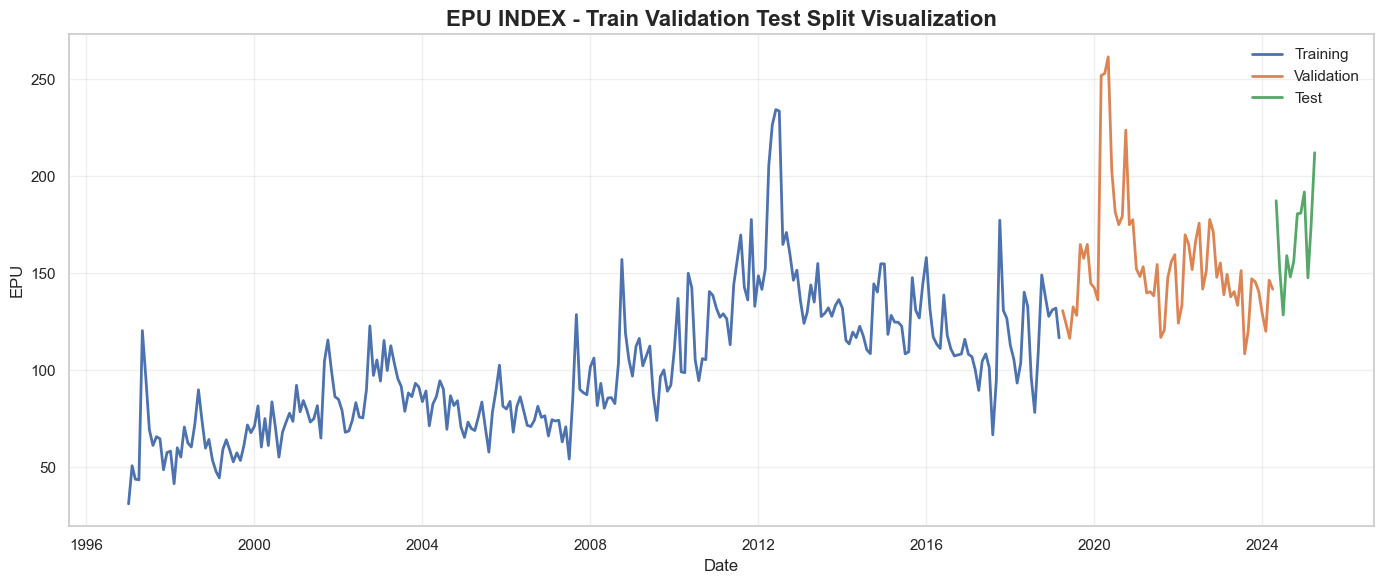

In [120]:
plt.figure(figsize=(14, 6))

plt.plot(dates_train, y_train, label='Training', linewidth=2)
plt.plot(dates_valid, y_valid, label='Validation', linewidth=2)
plt.plot(dates_test,  y_test,  label='Test', linewidth=2)

plt.title("EPU INDEX - Train Validation Test Split Visualization", fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('EPU')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


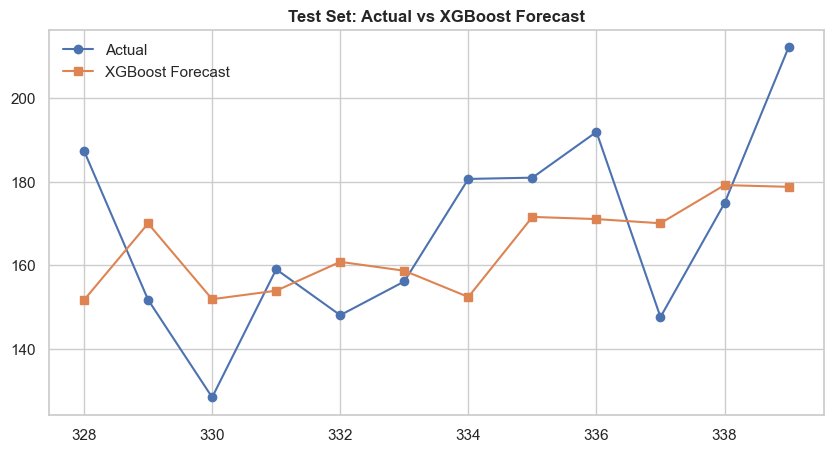

In [121]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='XGBoost Forecast', marker='s')
plt.title('Test Set: Actual vs XGBoost Forecast', fontweight='bold')
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

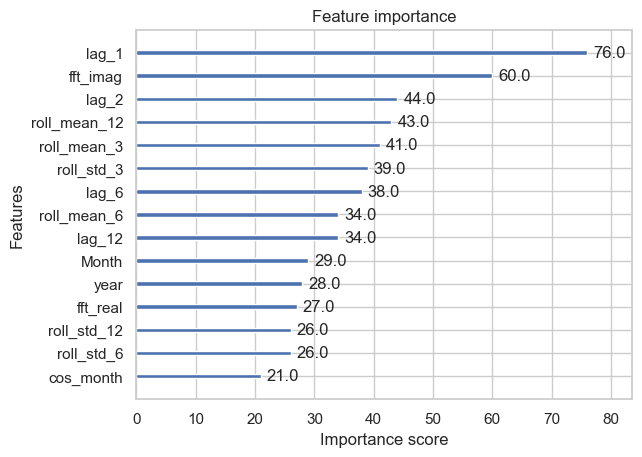

In [122]:
xgb.plot_importance(final_model, max_num_features=15)   

In [123]:
rmse_xgb = mean_squared_error(y_test, y_pred)
mae_xgb  = mean_absolute_error(y_test, y_pred)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred) * 100
mse_xgb = mean_squared_error(y_test, y_pred)

print(f"RMSE: {rmse_xgb:.3f}")
print(f"MAE : {mae_xgb:.3f}")
print(f"MAPE: {mape_xgb:.2f}%")
print(f"MSE : {mse_xgb:.3f}")

RMSE: 441.837
MAE : 18.026
MAPE: 10.65%
MSE : 441.837


 After analyzing volatility, the **XGBoost** model was applied to forecast the absolute EPU index values. Adding XGBoost allowed leveraging lag features, rolling statistics, and Fourier transforms to improve point forecasting accuracy.  
Results show **XGBoost achieved a low MAPE (10.65%)**, significantly better than the ARCH/GARCH models for point forecasts. This demonstrates that XGBoost is a strong tool for precise short-term predictions after understanding volatility dynamics with GARCH.  
**Conclusion:** This combined approach enables both volatility modeling (via GARCH) and improved point forecasting (via XGBoost), offering a more comprehensive understanding of the EPU time series.

##### 5.4.2. LONG SHORT-TERM MEMORY (LSTM)

In [124]:
df = fe_df.copy()
df['Date'] = pd.to_datetime(df['Date'])

features = [
    'EPU',
    'sin_month', 'cos_month',
    'lag_1', 'lag_2', 'lag_6', 'lag_12',
    'roll_mean_3', 'roll_std_3',
    'roll_mean_6', 'roll_std_6',
    'roll_mean_12', 'roll_std_12',
    'fft_real', 'fft_imag'
]

df = df[['Date'] + features]
df = df.dropna().reset_index(drop=True)


In [125]:
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])


n = len(df_scaled)
train_df = df_scaled.iloc[:int(0.70 * n)]
val_df   = df_scaled.iloc[int(0.70 * n):int(0.88 * n)]
test_df  = df_scaled.iloc[int(0.88 * n):]
print(f"Splits - Train:{len(train_df)}, Val:{len(val_df)}, Test:{len(test_df)}")

Splits - Train:229, Val:59, Test:40


In [126]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None, batch_size=32):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.label_columns = label_columns
        if label_columns:
            self.label_columns_indices = {name:i for i,name in enumerate(label_columns)}
        self.column_indices = {name:i for i,name in enumerate(train_df.columns)}
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns:
            labels = tf.stack(
                [labels[:,:, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        return inputs, labels
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=self.batch_size
        )
        return ds.map(self.split_window)
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    @property
    def sample_batch(self):
        return next(iter(self.train))

In [127]:
input_width  = 24
label_width  = 1
shift        = 12  
label_columns = ['EPU']

window = WindowGenerator(
    input_width, label_width, shift,
    train_df=train_df[features],
    val_df=val_df[features],
    test_df=test_df[features],
    label_columns=label_columns,
    batch_size=32
)
print(f"Window - input_width:{input_width}, shift:{shift}")

Window - input_width:24, shift:12


In [128]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(input_width, len(features))),
    Dropout(0.1),
    LSTM(64),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1)
])

opt = Adam(learning_rate=0.0005) #optimize model learning rate

model.compile(
    optimizer=opt,
    loss='mae',
    metrics=[
        MeanAbsoluteError(name='mae'),
        MeanSquaredError(name='mse'),
        MeanAbsolutePercentageError(name='mape')
    ]
)

model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    window.train,
    validation_data=window.val,
    epochs=100,
    callbacks=[early_stop],
    verbose=2
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 128)        │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,249 (489.25 KB)

 Trainable params: 125,249 (489.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
7/7 - 3s - 426ms/step - loss: 0.1642 - mae: 0.1642 - mape: 59.4854 - mse: 0.0459 - val_loss: 0.2397 - val_mae: 0.2397 - val_mape: 35.8652 - val_mse: 0.0935
Epoch 2/100
7/7 - 0s - 27ms/step - loss: 0.0917 - mae: 0.0917 - mape: 34.3217 - mse: 0.0164 - val_loss: 0.2128 - val_mae: 0.2128 - val_mape: 31.4707 - val_mse: 0.0816
Epoch 3/100
7/7 - 0s - 29ms/step - loss: 0.0891 - mae: 0.0891 - mape: 32.9392 - mse: 0.0149 - val_loss: 0.2464 - val_mae: 0.2464 - val_mape: 37.0195 - val_mse: 0.1010
Epoch 4/100
7/7 - 0s - 28ms/step - loss: 0.0949 - mae: 0.0949 - mape: 32.2608 - mse: 0.0172 - val_loss: 0.2264 - val_mae: 0.2264 - val_mape: 33.6991 - val_mse: 0.0898
Epoch 5/100
7/7 - 0s - 27ms/step - loss: 0.0963 - mae: 0.0963 - mape: 31.6547 - mse: 0.0195 - val_loss: 0.2007 - val_mae: 0.2007 - val_mape: 29.4534 - val_mse: 0.0763
Epoch 6/100
7/7 - 0s - 25ms/step - loss: 0.0918 - mae: 0.0918 - mape: 36.7010 - mse: 0.0150 - val_loss: 0.2470 - val_mae: 0.2470 - val_mape: 37.0361 - val_mse: 0.09

In [129]:
results = model.evaluate(window.test, verbose=0)
print(f"\nTest MAE : {results[1]:.4f}")
print(f"Test MSE : {results[2]:.4f}")
print(f"Test MAPE: {results[3]:.2f}%")


Test MAE : 0.1800
Test MSE : 0.0421
Test MAPE: 26.47%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


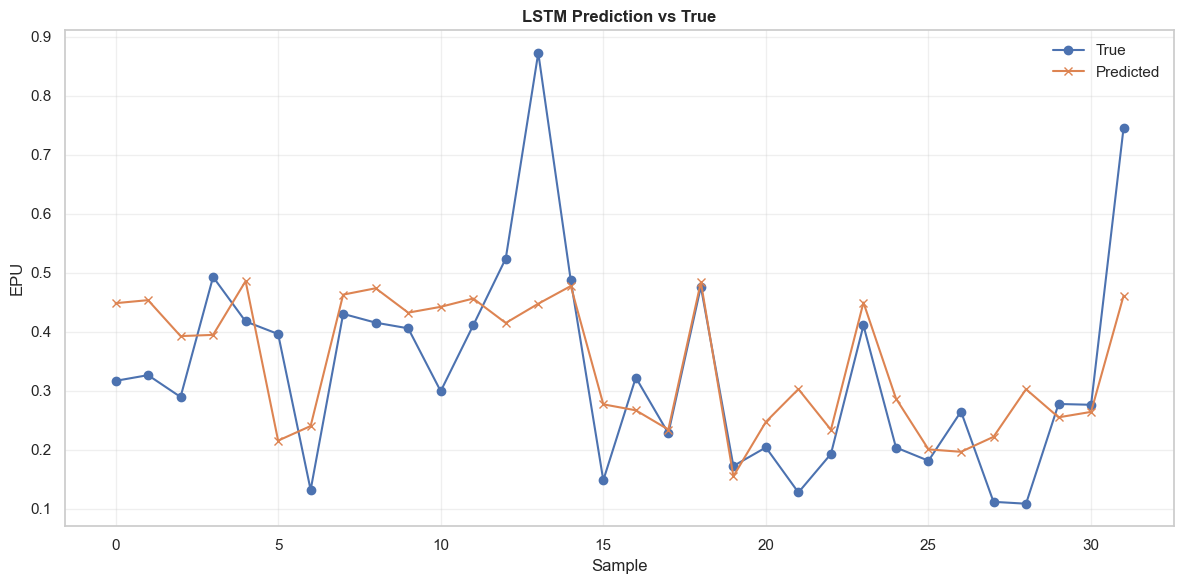

In [130]:
inputs, labels = window.sample_batch
predictions = model.predict(inputs)

plt.figure(figsize=(12,6))
plt.plot(labels[:,0,0], label='True', marker='o')
plt.plot(predictions[:,0], label='Predicted', marker='x')
plt.title(f'LSTM Prediction vs True', fontweight='bold')
plt.xlabel('Sample')
plt.ylabel('EPU')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


- The LSTM model trained to forecast EPU values with a 12-step horizon shows **clear improvement** over previous tests. The predicted curve is no longer flat and now reacts better to actual variations, tracking the **main trend and long-term cycles** in the data.

- The results demonstrate that forecasts **closely follow** most of the time series’ oscillations, with a similar wave shape and the ability to predict overall upward and downward phases. This indicates that the LSTM has **learned long-term relationships** thanks to richer input features (extended lags, rolling means/stds, FFT components).

- However, the model still has **limitations**: at extreme spikes, predictions tend to be **smoothed**, failing to match the true peaks or troughs. This is a common issue in LSTM with long forecasting horizons, as loss functions like MAE encourage minimizing average error rather than perfectly fitting extremes.

- Additionally, there is **slight phase shift** in some places, reflecting the inherently challenging nature of forecasting the EPU series, which contains noise and unstable volatility.

- **Conclusion:** The current results show that an LSTM model with a 12-step horizon and well-designed feature engineering **can reasonably forecast medium-term trends** and hidden cycles in the EPU index. Although not perfect at extreme spikes, this remains a **practical and valuable result** for supporting economic analysis and policy planning for SPAIN.

### 6. REFERENCES

https://github.com/tphathuin1802/python-time-series/blob/main/notebook/projects/etf-price-prediction.ipynb <br> https://github.com/tphathuin1802/python-time-series/tree/main/notebook/deep_learning <br> https://www.youtube.com/@aivietnam-edu-vn

#### <br> <br> © 2025 by HUYNH TAN PHAT. All rights reserved.

Github link: https://github.com/tphathuin1802/spain-epu-time-series-forecasting